# Import packages and functions

In [1]:
import sys
# force the notebook to look for files in the upper level directory
sys.path.insert(1, '../')

In [2]:
import numpy as np
import pandas as pd
import pymatgen as mg
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
from data.plotting import periodic_table_heatmap

# Set up constants

In [3]:
FULL_PATH = "../data/processed/IMT_Classification_Dataset_Full_Feature_Set_v10.xlsx"
METAL_SUMMARY_PATH = "../data/dataset_summary/metal_summary_processed.xlsx"
INSULATOR_SUMMARY_PATH = "../data/dataset_summary/insulator_summary_processed.xlsx"
MIT_SUMMARY_PATH = "../data/dataset_summary/mit_summary_processed.xlsx"
ML_METRICS_PATH = "../data/processed/model_metrics_comparison_with_raw.xlsx"
HUMAN_METRICS_PATH = "../data/human_binary_classification_results.csv"
SAVE_PATH = "../plots/"
SAVE_PLOT = True

# Define some helper functions

In [4]:
def return_num_elem(compound_name):
    """Return the number of elements in a compound as one of 'binary', 'ternary', 'quarternary'"""
    num_elems_str = "Other"
    num_elems = len(mg.Composition(compound_name).elements) 
    if num_elems == 2:
        num_elems_str = "Binary"
    elif num_elems == 3:
        num_elems_str = "Ternary"
    elif num_elems == 4:
        num_elems_str = "Quarternary"
    return num_elems_str


def autolabel(ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    
    Code adapted from https://matplotlib.org/3.3.1/gallery/lines_bars_and_markers/barchart.html
    """
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0.5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=24)

# Read in data

In [5]:
df_plot = pd.read_excel(FULL_PATH)
df_plot = df_plot.replace({"Label": {0: "Metal", 1: "Insulator", 2: "MIT"}})

In [6]:
df_plot

Compound  Label                                   struct_file_path  \
0      Ba(FeSb3)4  Metal  ../data/Structures/Metals/BaFe4Sb12_CollCode_6...   
1        Ba(NiP)2  Metal   ../data/Structures/Metals/BaNi2P2_SD_1701656.cif   
2        Ba(PIr)2  Metal  ../data/Structures/Metals/BaIr2P2_CollCode_957...   
3        Ba(PRh)2  Metal  ../data/Structures/Metals/BaRh2P2_CollCode_501...   
4      Ba(Sb3Os)4  Metal  ../data/Structures/Metals/BaOs4Sb12_CollCode_6...   
..            ...    ...                                                ...   
338           VO2    MIT  ../data/Structures/MIT_materials/HighT/VO2_HT_...   
339         YCoO3    MIT  ../data/Structures/MIT_materials/HighT/YCoO3_C...   
340   YFe4(CuO4)3    MIT  ../data/Structures/MIT_materials/HighT/YCu3Fe4...   
341         YNiO3    MIT  ../data/Structures/MIT_materials/HighT/YNiO3_6...   
342  YbFe4(CuO4)3    MIT  ../data/Structures/MIT_materials/HighT/YbCu3Fe...   

     range_MendeleevNumber  mean_MendeleevNumber  avg_dev_MendeleevNumber  \
0                       76             73.470588                16.276817   
1                       74             59.400000                20.160000   
2                       74             59.000000                20.000000   
3                       74             58.600000                19.840000   
4                       76             73.941176                15.612457   
..                     ...                   ...                      ...   
338                     41             73.333333                18.222222   
339                     75             66.200000                24.960000   
340                     75             73.400000                16.320000   
341                     75             66.800000                24.240000   
342                     48             74.750000                14.700000   

     maximum_AtomicWeight  range_AtomicWeight  mean_AtomicWeight  \
0               137.32700           81.482000         107.166294   
1               137.32700          106.353238          63.332265   
2               192.21700          161.243238         116.741705   
3               137.32700          106.353238          81.017105   
4               190.23000           68.470000         138.786294   
..                    ...                 ...                ...   
338              50.94150           34.942100          27.646767   
339              88.90585           72.906450          39.167449   
340              88.90585           72.906450          34.745832   
341              88.90585           72.906450          39.119490   
342             173.05400          157.054600          38.953240   

     avg_dev_AtomicWeight  ...  avg_mx_dists  max_xx_dists  min_xx_dists  \
0               24.151197  ...      2.596481      3.450762      2.871024   
1               29.597894  ...      2.259574      3.709116      3.554335   
2               68.614354  ...      2.355169      3.794974      3.713769   
3               40.034674  ...      2.346291      3.776568      3.737587   
4               24.208803  ...      2.635420      3.502512      2.914080   
..                    ...  ...           ...           ...           ...   
338             15.529822  ...      1.927294      2.725617      2.575183   
339             27.801659  ...      1.933264      3.527817      2.699880   
340             22.495719  ...      2.356918      2.896772      2.559157   
341             27.744108  ...      1.963601      3.184308      2.736503   
342             27.544608  ...      2.365615      2.924013      2.552849   

     avg_xx_dists        v_m        v_x     iv_p1  est_hubbard_u  \
0        3.266718 -23.735803   9.622199  54.91000      21.129322   
1        3.631725 -22.390084  28.414957  35.18700      11.858755   
2        3.754372 -20.210211  27.763527  28.00000       5.839285   
3        3.757078 -20.397126  27.833127  31.06000       7.810114   
4        3.315708 -23.385103   9.480030  41.00000      12.916563 

# Periodic table heatmaps
**Note**: this part won't be able to run on Binder or a forked local repository since the original CIFs are needed, which we can't share due to copyright concerns.

In [7]:
pos_classes = ["Metal", "Insulator", "MIT", "All"]

In [8]:
# read in all the structures from the full-feature training set
structures = {pos_class: [mg.Structure.from_file(path) for path in df_plot[df_plot.Label == pos_class].struct_file_path.to_list()] 
              if pos_class != "All" else [mg.Structure.from_file(path) for path in df_plot.struct_file_path.to_list()] for pos_class in pos_classes}

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/pymatgen/io/cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [9]:
def count_elem(structs):
    """Count the percentage of compounds that have the corresponding element"""
    elem_count = {}
    num_compound = len(structs)
    for structure in structs:
        elem_lst = structure.composition.element_composition.to_data_dict["elements"]
        for elem in elem_lst:
            if elem not in elem_count.keys():
                elem_count[elem] = 100. / num_compound
            else:
                elem_count[elem] += 100. / num_compound
    return elem_count

## Heatmap for all compounds

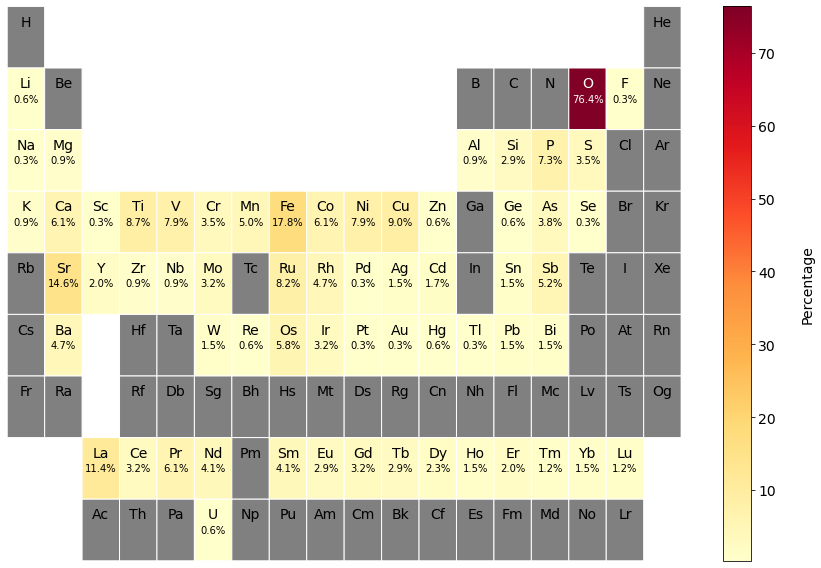

In [10]:
elem_heatmap_all = periodic_table_heatmap(count_elem(structures["All"]), value_format="%.1f%%", 
                                          cbar_label="Percentage")

## Heatmap for only metals

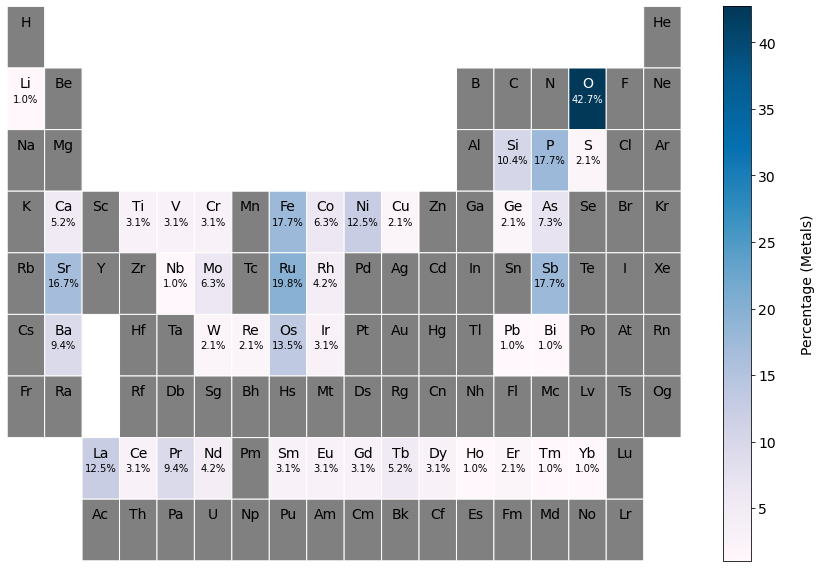

In [11]:
elem_heatmap_metal = periodic_table_heatmap(count_elem(structures["Metal"]), value_format="%.1f%%", cmap="PuBu", 
                                            cbar_label="Percentage (Metals)")

## Heatmap for only insulators

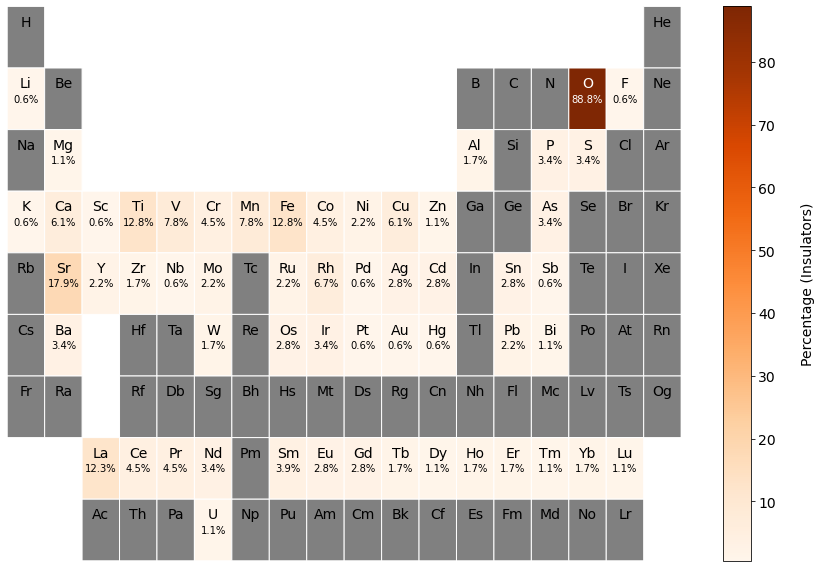

In [12]:
elem_heatmap_insulator = periodic_table_heatmap(count_elem(structures["Insulator"]), value_format="%.1f%%", cmap="Oranges", 
                                                cbar_label="Percentage (Insulators)")

## Heatmap for only MITs

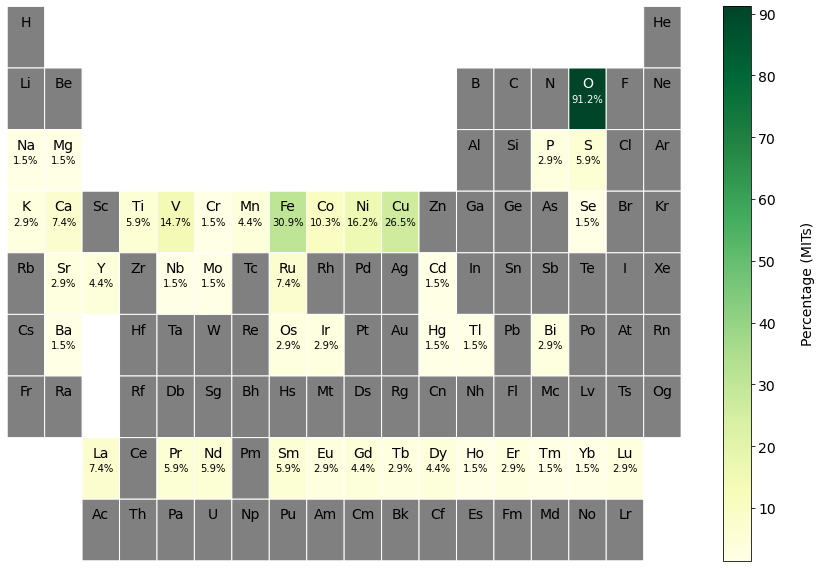

In [13]:
elem_heatmap_mit = periodic_table_heatmap(count_elem(structures["MIT"]), value_format="%.1f%%", cmap="YlGn", 
                                          cbar_label="Percentage (MITs)")

In [14]:
if SAVE_PLOT: 
    elem_heatmap_all.figure.savefig(SAVE_PATH + "element_heatmap_all.pdf", dpi=300, bbox_inches="tight")
    elem_heatmap_metal.figure.savefig(SAVE_PATH + "element_heatmap_metal.pdf", dpi=300, bbox_inches="tight")
    elem_heatmap_insulator.figure.savefig(SAVE_PATH + "element_heatmap_insulator.pdf", dpi=300, bbox_inches="tight")
    elem_heatmap_mit.figure.savefig(SAVE_PATH + "element_heatmap_mit.pdf", dpi=300, bbox_inches="tight")

# Pairplot of 10 most important features for the MIT vs. non-MIT model

In [15]:
# handpicked ones
features_to_include = ["Label", # used for color coding
                       "gii",
                       "avg_dev_CovalentRadius",
                       "ewald_energy_per_atom",
                       "range_MendeleevNumber",
                       "avg_mm_dists",
                       "est_hubbard_u",
                       "est_charge_trans",
                       "avg_mx_dists",
                       "avg_xx_dists",
                       "avg_dev_Electronegativity"
                      ]

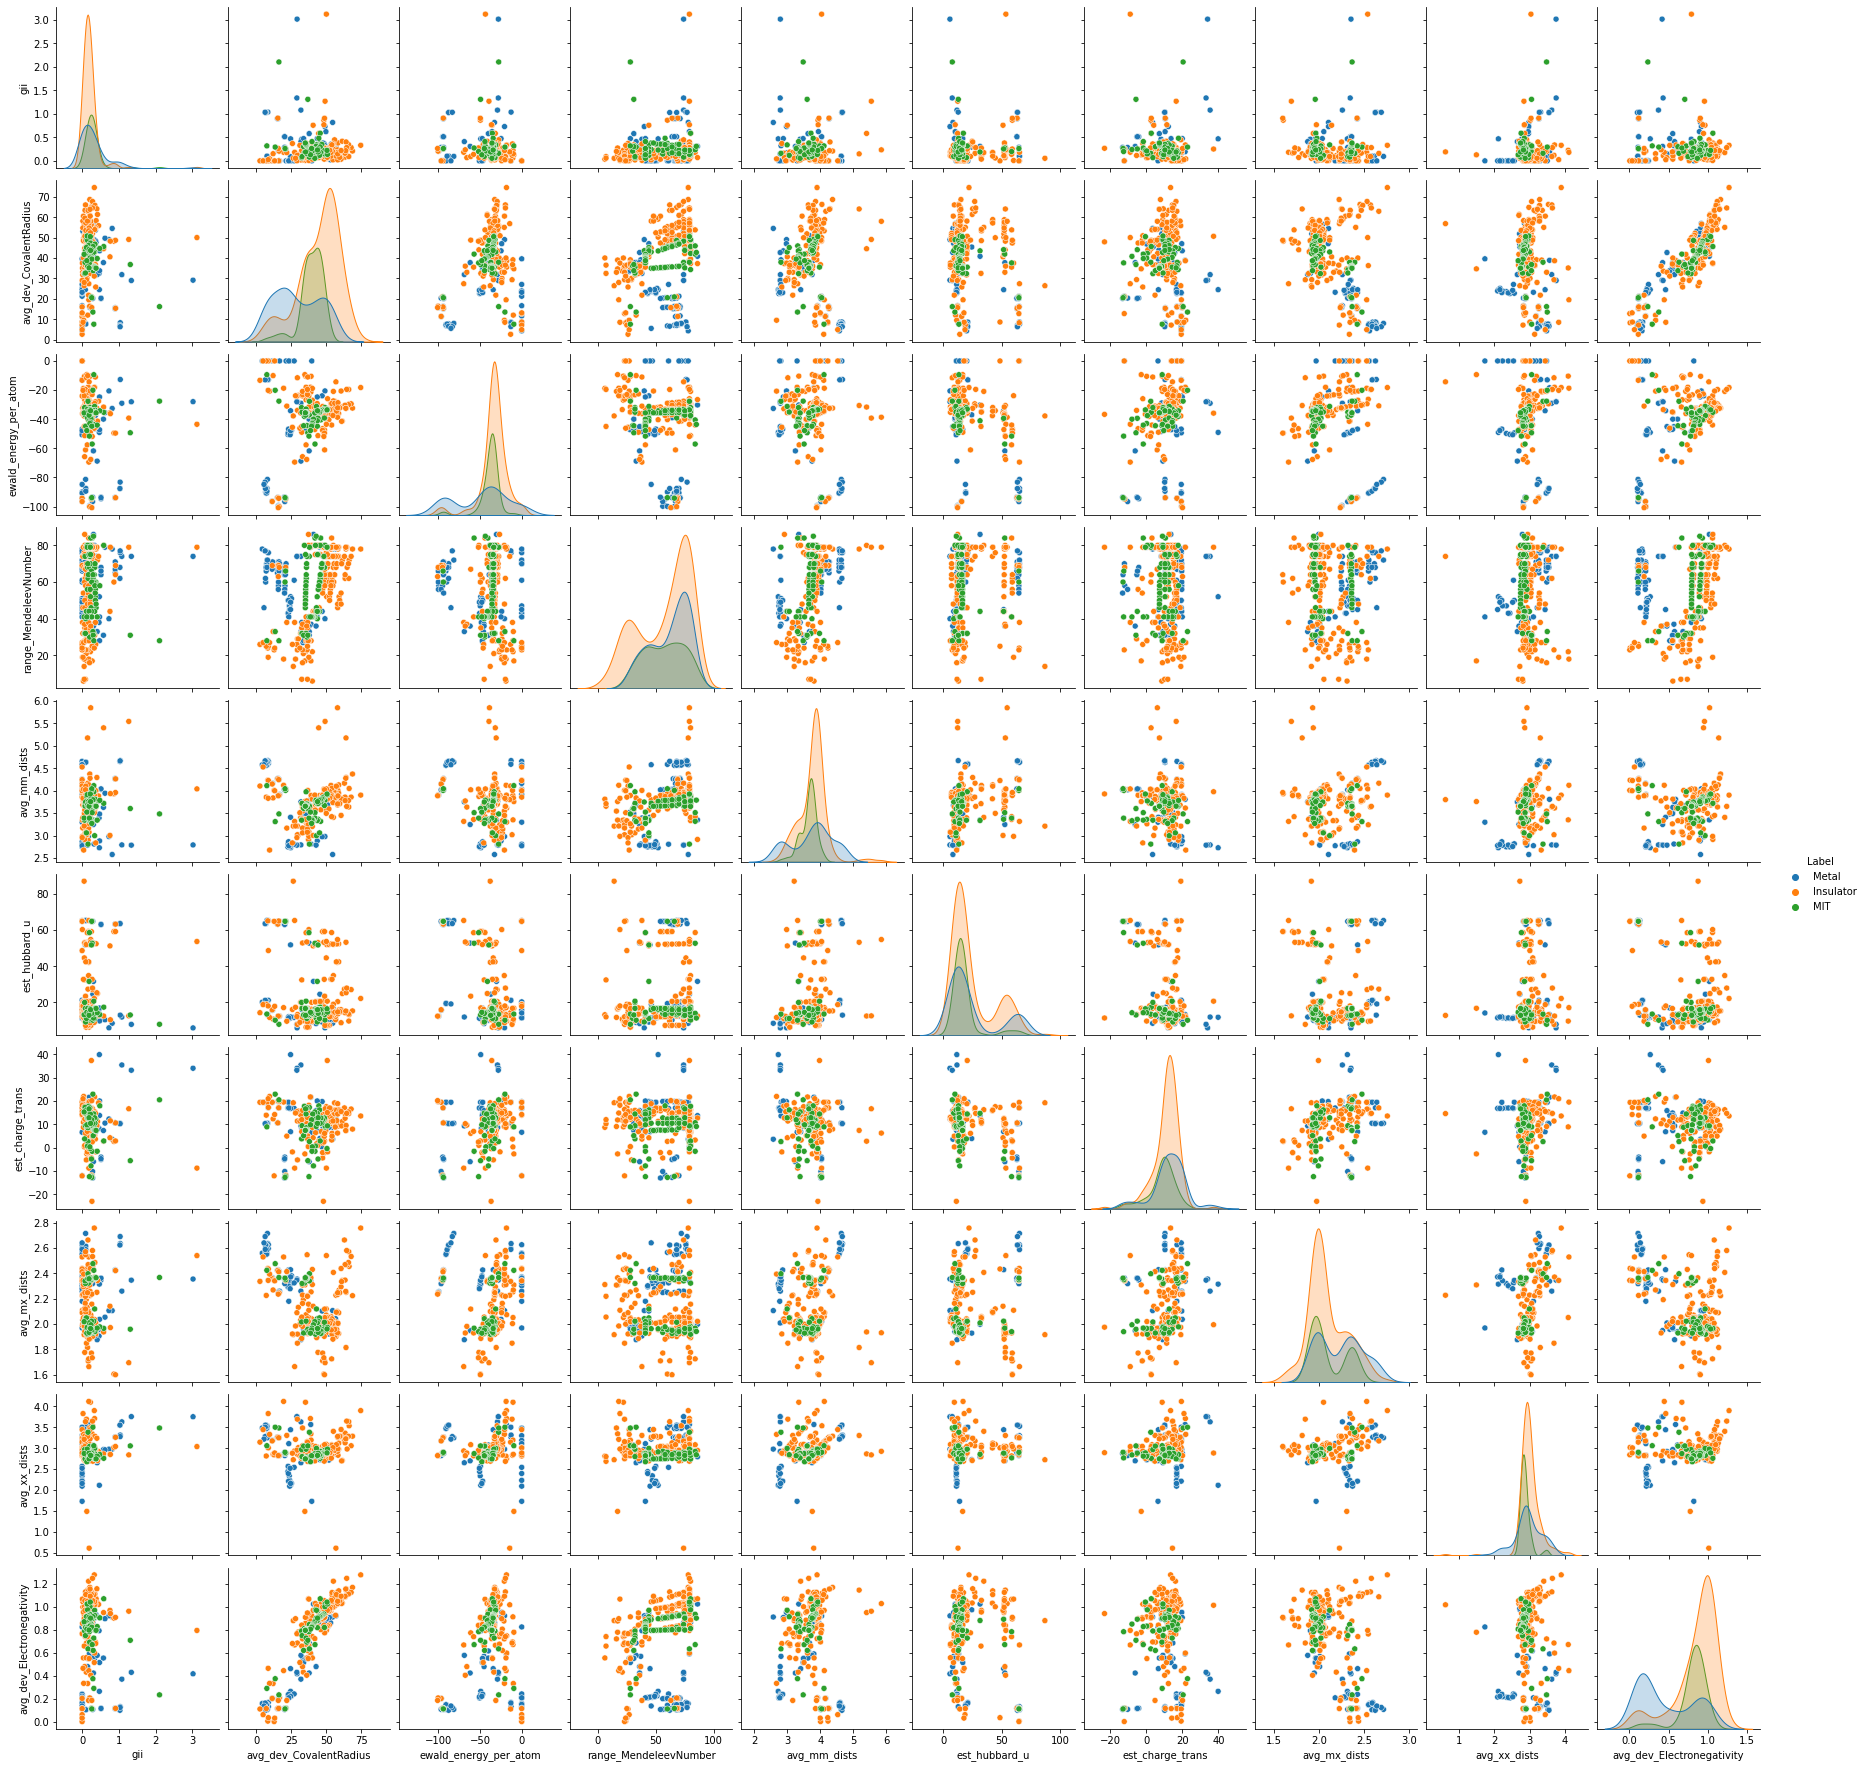

In [16]:
handpicked_features_pairwise_plot = sns.pairplot(df_plot[features_to_include], hue="Label")

In [17]:
if SAVE_PLOT: handpicked_features_pairwise_plot.fig.savefig(SAVE_PATH + "handpicked_features_pairwise_plot.pdf", dpi=300, bbox_inches="tight")

In [18]:
# ones selected based on SHAP values from the MIT classifier trained on the full feature set
features_to_include = ["Label", 
                       "mean_CovalentRadius",
                       "avg_dev_CovalentRadius",
                       "volume_per_site",
                       "avg_dev_neighbor_distance_variation",
                       "mean_GSvolume_pa",
                       "min_mx_dists",
                       "gii",
                       "range_neighbor_distance_variation",
                       "avg_mm_dists",
                       "est_hubbard_u"]

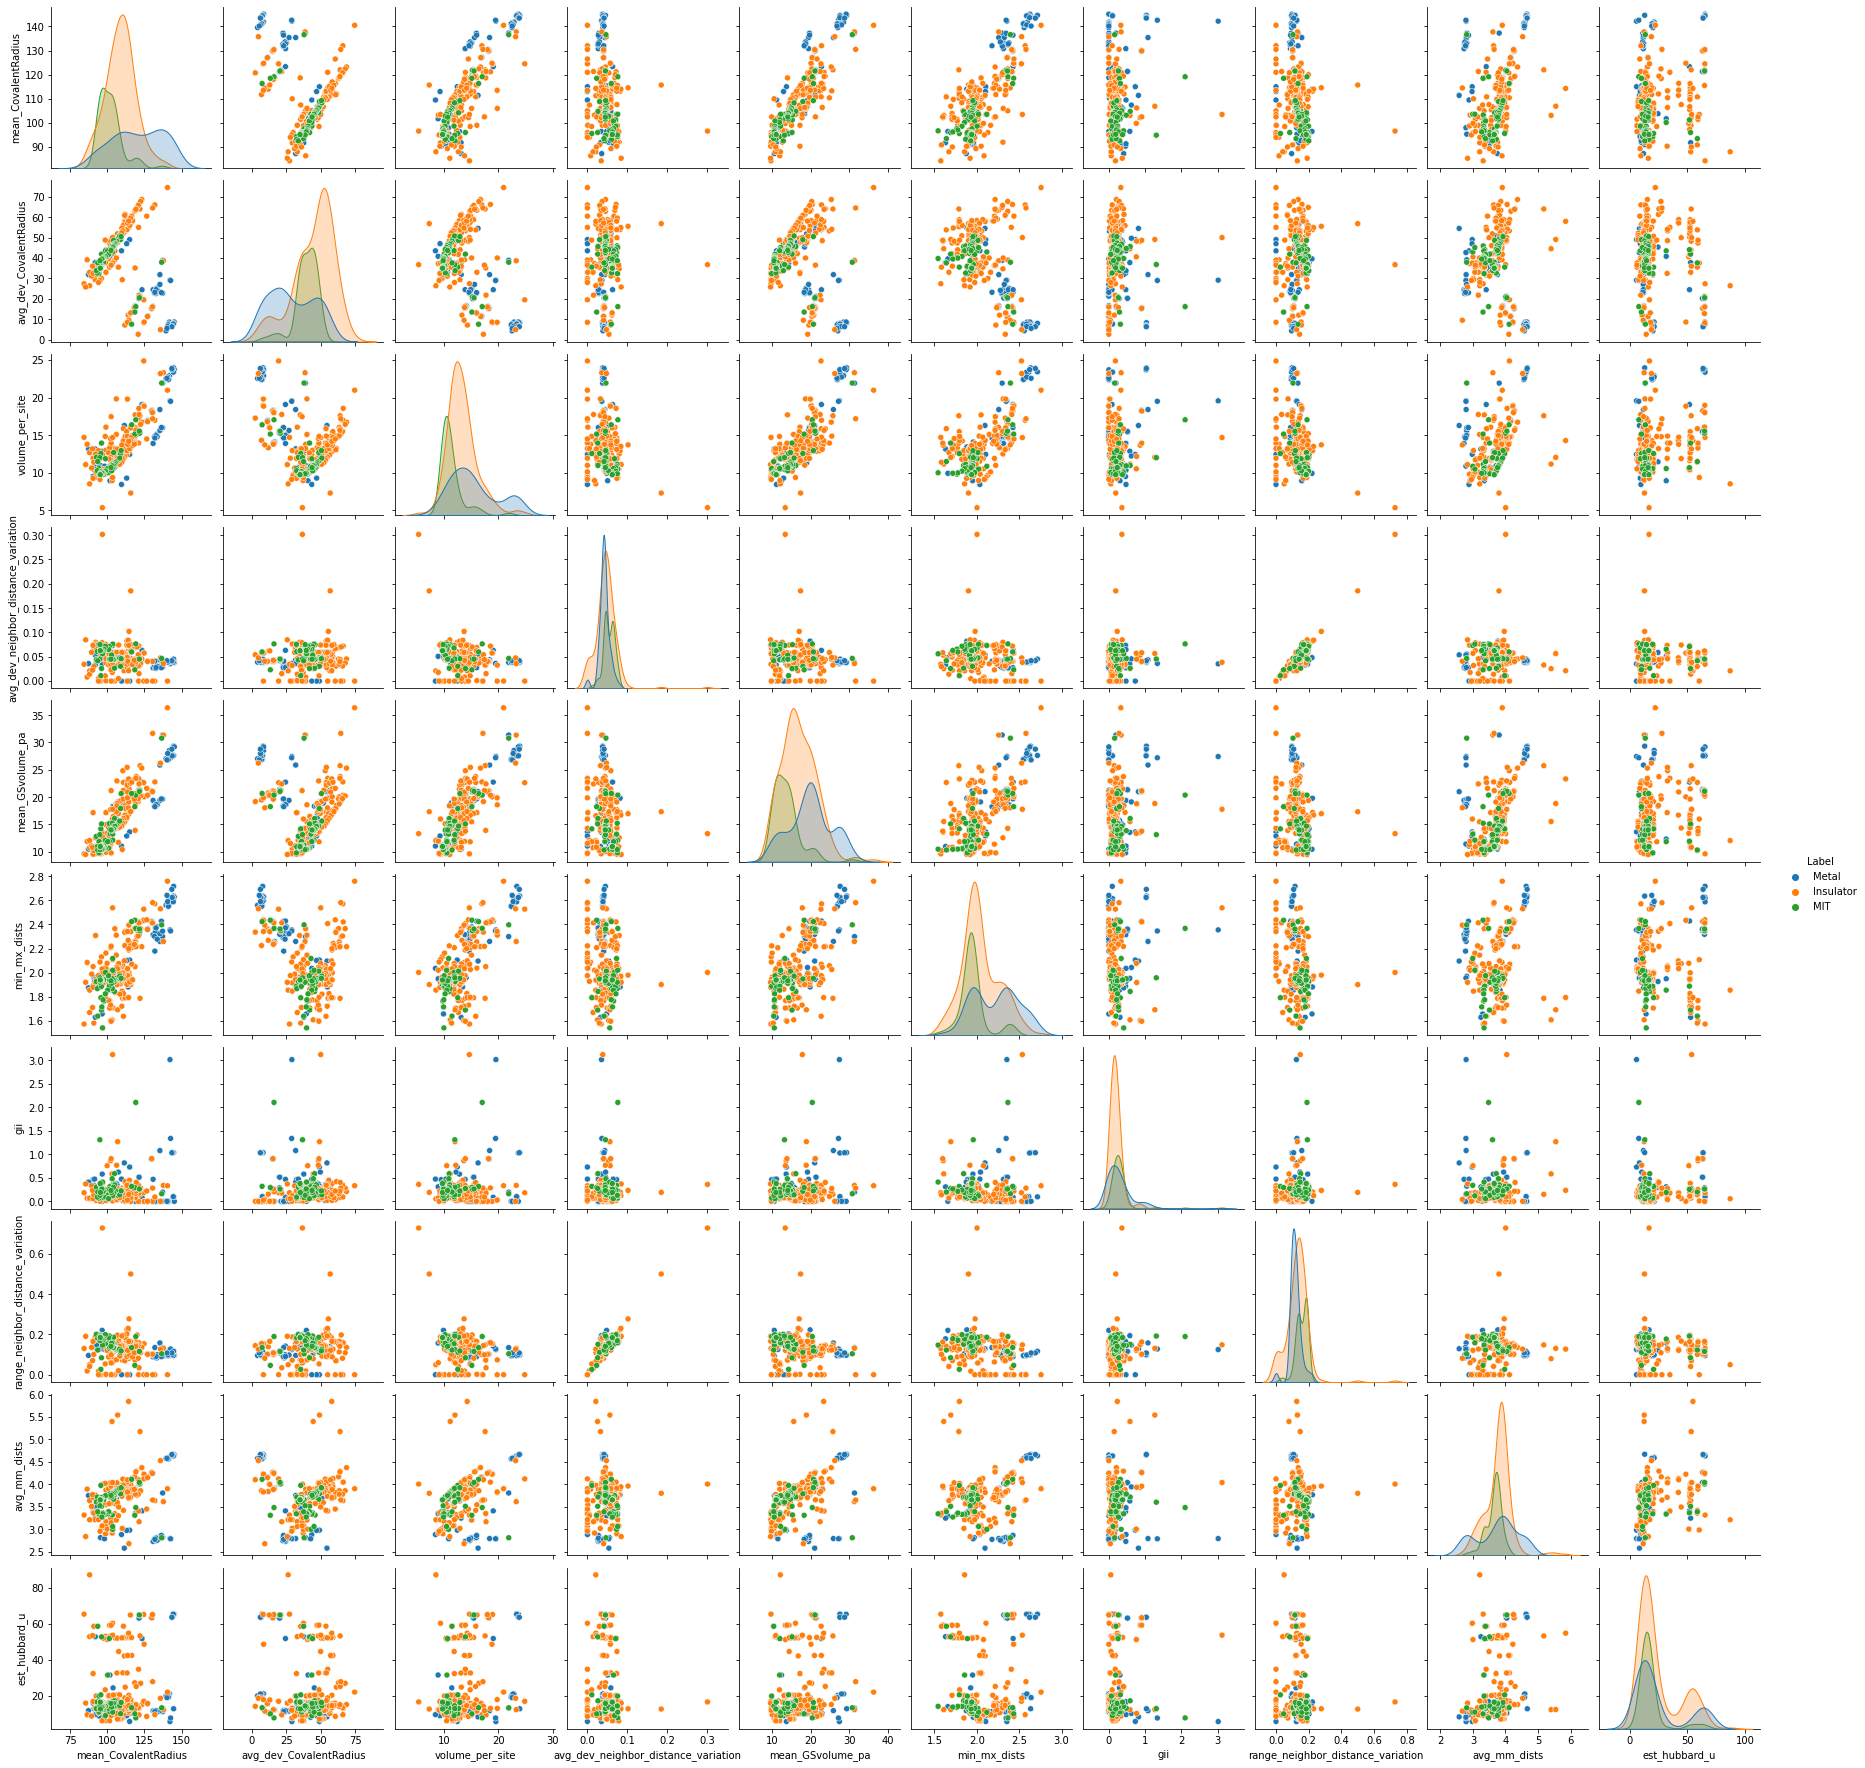

In [19]:
shap_features_pairwise_plot = sns.pairplot(df_plot[features_to_include], hue="Label")

In [20]:
if SAVE_PLOT: shap_features_pairwise_plot.fig.savefig(SAVE_PATH + "shap_features_pairwise_plot.pdf", dpi=300, bbox_inches="tight")

# Plot the number of element distribution within each class

In [21]:
# set the font size for annotation
font = {'size': 22}
mpl.rc('font', **font)

df_plot["num_elem"] = df_plot["Compound"].apply(return_num_elem)

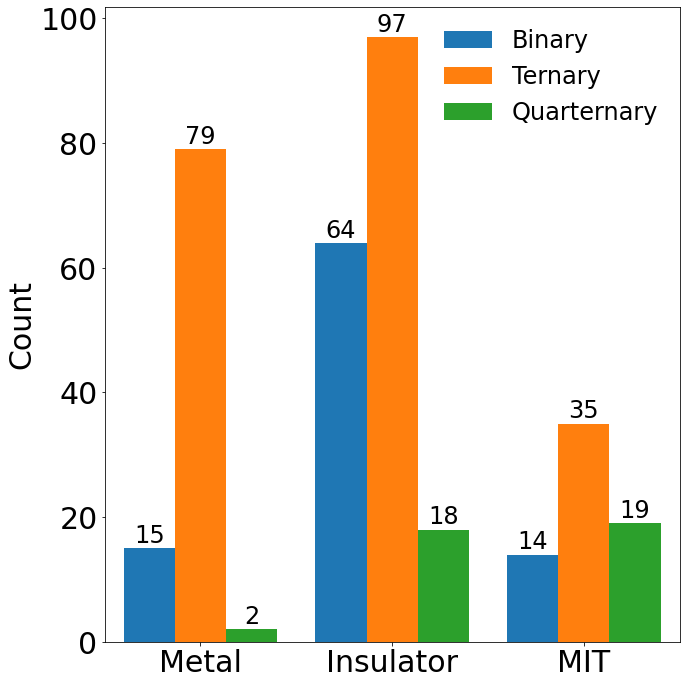

In [22]:
plt.figure(figsize=(10,10))
class_dist = sns.countplot(data=df_plot, x="Label", hue="num_elem", hue_order=["Binary", "Ternary", "Quarternary"],
                           saturation=1)
autolabel(class_dist)
class_dist.set_xlabel(None)
class_dist.set_ylabel("Count", fontsize=30)
class_dist.tick_params(labelsize=30)
class_dist.legend(fontsize=24, frameon=False)
plt.tight_layout()

In [23]:
if SAVE_PLOT: class_dist.figure.savefig(SAVE_PATH + "class_distribution_new.pdf", dpi=300, bbox_inches="tight")

# Plot the estimated charge transfer energy vs. estimate Hubbard U

In [24]:
x_plot = "est_charge_trans"
y_plot = "est_hubbard_u"
# get the relevant columns from the training set
df_charge_transfer_hubbard_plot = df_plot[["Compound", "Label", x_plot, y_plot]]
df_charge_transfer_hubbard_plot

Compound  Label  est_charge_trans  est_hubbard_u
0      Ba(FeSb3)4  Metal         19.461062      21.129322
1        Ba(NiP)2  Metal         35.445979      11.858755
2        Ba(PIr)2  Metal         34.042180       5.839285
3        Ba(PRh)2  Metal         33.195560       7.810114
4      Ba(Sb3Os)4  Metal         10.425355      12.916563
..            ...    ...               ...            ...
338           VO2    MIT          9.779242      14.484546
339         YCoO3    MIT         12.815560      13.895560
340   YFe4(CuO4)3    MIT         16.608178      12.807177
341         YNiO3    MIT         10.393278      15.898371
342  YbFe4(CuO4)3    MIT          7.361181      16.597335

[343 rows x 4 columns]

In [25]:
charge_trans_min, charge_trans_max = 0, 21
hubbard_u_min, hubbard_u_max = 0, 30

In [26]:
print("Percentage of points plotted: :{:0.2f}%".format(
df_charge_transfer_hubbard_plot.loc[((df_charge_transfer_hubbard_plot.est_charge_trans >= charge_trans_min) & 
                                     (df_charge_transfer_hubbard_plot.est_charge_trans <= charge_trans_max)) &
                                    ((df_charge_transfer_hubbard_plot.est_hubbard_u >= hubbard_u_min) &
                                     (df_charge_transfer_hubbard_plot.est_hubbard_u <= hubbard_u_max))].shape[0] / df_charge_transfer_hubbard_plot.shape[0] * 100
    )
)

Percentage of points plotted: :72.59%


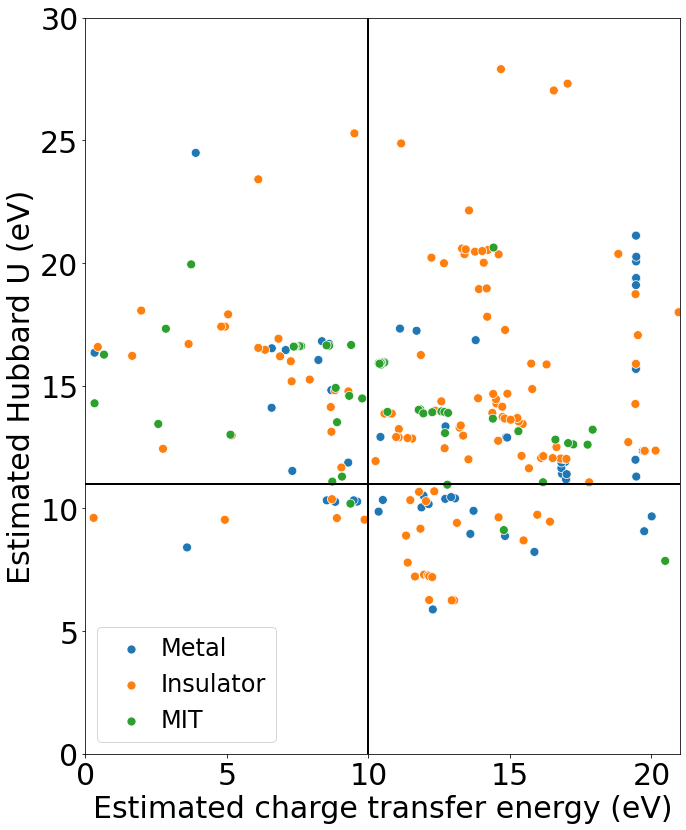

In [27]:
plt.figure(figsize=(10,12))
charge_hubbard = sns.scatterplot(data=df_charge_transfer_hubbard_plot, x=x_plot, y=y_plot, hue="Label", s=80)
charge_hubbard.set_xlabel("Estimated charge transfer energy (eV)", fontsize=30)
charge_hubbard.set_ylabel("Estimated Hubbard U (eV)", fontsize=30)
charge_hubbard.set_xlim(charge_trans_min, charge_trans_max)
charge_hubbard.set_ylim(hubbard_u_min, hubbard_u_max)
charge_hubbard.axvline(10, color='k', linestyle='-', linewidth=2)
charge_hubbard.axhline(11, color='k', linestyle='-', linewidth=2)
charge_hubbard.legend(loc='lower left', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
charge_hubbard.tick_params(labelsize=30)
plt.tight_layout()

In [28]:
if SAVE_PLOT: charge_hubbard.figure.savefig(SAVE_PATH + "torrance_features_subset.pdf", dpi=300, bbox_inches="tight")

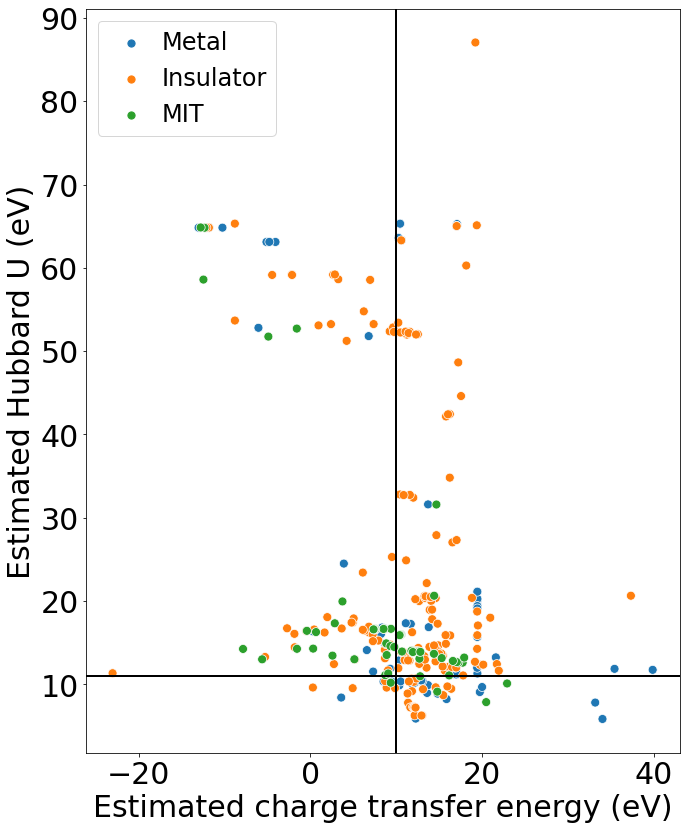

In [29]:
plt.figure(figsize=(10,12))
charge_hubbard = sns.scatterplot(data=df_charge_transfer_hubbard_plot, x=x_plot, y=y_plot, hue="Label", s=80)
charge_hubbard.set_xlabel("Estimated charge transfer energy (eV)", fontsize=30)
charge_hubbard.set_ylabel("Estimated Hubbard U (eV)", fontsize=30)
charge_hubbard.axvline(10, color='k', linestyle='-', linewidth=2)
charge_hubbard.axhline(11, color='k', linestyle='-', linewidth=2)
charge_hubbard.legend(loc='upper left', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
charge_hubbard.tick_params(labelsize=30)
plt.tight_layout()

In [30]:
if SAVE_PLOT: charge_hubbard.figure.savefig(SAVE_PATH + "torrance_features_full.pdf", dpi=300, bbox_inches="tight")

# Plot the GII vs. the Average Deviation of the Covalent Radius

In [31]:
x_plot = "gii"
y_plot = "avg_dev_CovalentRadius"
# get the relevant columns from the training set
df_gii_cov_radius_plot = df_plot[["Compound", "Label", x_plot, y_plot]]
df_gii_cov_radius_plot

Compound  Label       gii  avg_dev_CovalentRadius
0      Ba(FeSb3)4  Metal  0.000000                8.608997
1        Ba(NiP)2  Metal  1.080042               31.840000
2        Ba(PIr)2  Metal  3.015802               29.120000
3        Ba(PRh)2  Metal  1.337935               28.960000
4      Ba(Sb3Os)4  Metal  1.037038                8.276817
..            ...    ...       ...                     ...
338           VO2    MIT  0.128538               38.666667
339         YCoO3    MIT  0.188213               44.160000
340   YFe4(CuO4)3    MIT  0.188611               35.160000
341         YNiO3    MIT  0.231001               43.680000
342  YbFe4(CuO4)3    MIT  0.379838               34.980000

[343 rows x 4 columns]

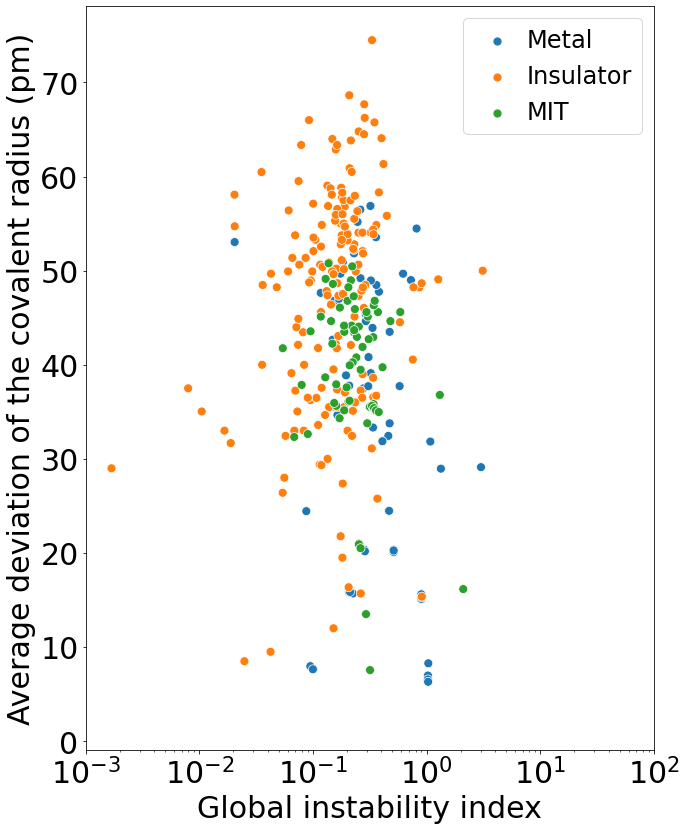

In [32]:
plt.figure(figsize=(10,12))
gii_cov_radius = sns.scatterplot(data=df_gii_cov_radius_plot, x=x_plot, y=y_plot, hue="Label", s=80)
gii_cov_radius.set_xscale("log")
gii_cov_radius.set_xlim(0.001, 100)
gii_cov_radius.set_xlabel("Global instability index", fontsize=30)
gii_cov_radius.set_ylabel("Average deviation of the covalent radius (pm)", fontsize=30)
gii_cov_radius.legend(loc='upper right', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
gii_cov_radius.tick_params(labelsize=30)
plt.tight_layout()

In [33]:
if SAVE_PLOT: gii_cov_radius.figure.savefig(SAVE_PATH + "gii_cov_radius.pdf", dpi=300, bbox_inches="tight")

Create an interactive plot of ADCR vs. GII for annotation

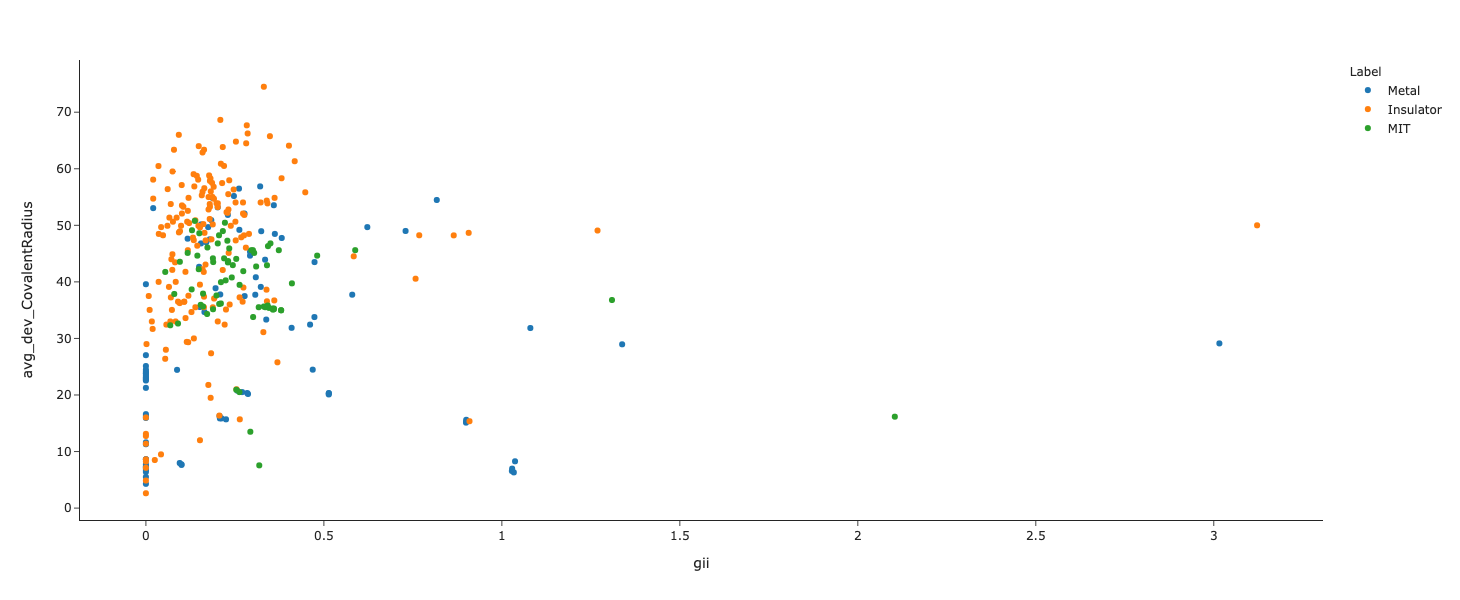

In [34]:
adcr_gii_fig = px.scatter(df_gii_cov_radius_plot, x=x_plot, y=y_plot, hover_name="Compound", 
                          hover_data=[df_gii_cov_radius_plot.index], color="Label", template="simple_white", 
                          width=500, height=600)
adcr_gii_fig.show()

Text(40, -4.7, 'Ca$_4$Mn$_3$O$_{10}$')

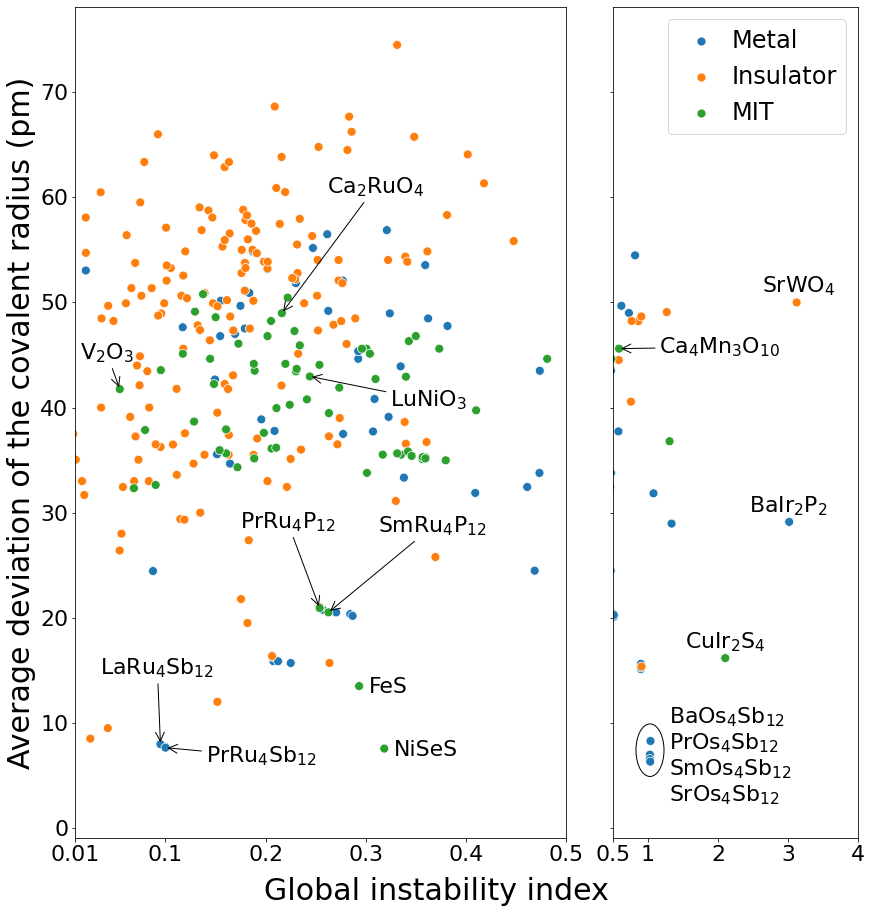

In [35]:
e2 = Ellipse((1.03, 7.4), width=0.4, height=5, fill=False, color="black")
gii_cov_radius_fig = plt.figure(figsize=(12,12), constrained_layout=True)
gs = gii_cov_radius_fig.add_gridspec(1, 3)
# PART 1
gii_cov_radius_part1 = gii_cov_radius_fig.add_subplot(gs[0, :-1])
sns.scatterplot(data=df_gii_cov_radius_plot, x=x_plot, y=y_plot, hue="Label", s=80, ax=gii_cov_radius_part1, legend=False)
gii_cov_radius_part1.set_xlim(0.01, 0.5)
gii_cov_radius_part1.set_xticks([0.01, 0.1, 0.2, 0.3, 0.4, 0.5])
gii_cov_radius_part1.set_xticklabels([0.01, 0.1, 0.2, 0.3, 0.4, 0.5])
gii_cov_radius_part1.set_xlabel(None)
gii_cov_radius_part1.set_ylabel("Average deviation of the covalent radius (pm)", fontsize=30)
# annotate FeS
gii_cov_radius_part1.annotate(r"FeS", (df_gii_cov_radius_plot[x_plot][293], df_gii_cov_radius_plot[y_plot][293]), 
                              textcoords = "offset points", xytext = (10, -7))
# annotate NiSeS
gii_cov_radius_part1.annotate(r"NiSeS", (df_gii_cov_radius_plot[x_plot][313], df_gii_cov_radius_plot[y_plot][313]), 
                              textcoords = "offset points", xytext = (10, -7))
# annotate LaRu4Sb12
gii_cov_radius_part1.annotate(r"LaRu$_4$Sb$_{12}$", (df_gii_cov_radius_plot[x_plot][38], df_gii_cov_radius_plot[y_plot][38]), 
                              textcoords = "offset points", xytext = (-60, 70),
                              arrowprops=dict(arrowstyle = "->"))
# annotate PrRu4Sb12
gii_cov_radius_part1.annotate(r"PrRu$_4$Sb$_{12}$", (df_gii_cov_radius_plot[x_plot][58], df_gii_cov_radius_plot[y_plot][58]), 
                              textcoords = "offset points", xytext = (40, -15),
                              arrowprops=dict(arrowstyle = "->"))
# annotate PrRu4P12
gii_cov_radius_part1.annotate(r"PrRu$_4$P$_{12}$", (df_gii_cov_radius_plot[x_plot][314], df_gii_cov_radius_plot[y_plot][314]), 
                              textcoords = "offset points", xytext = (-80, 80),
                              arrowprops=dict(arrowstyle = "->"))
# annotate SmRu4P12
gii_cov_radius_part1.annotate(r"SmRu$_4$P$_{12}$", (df_gii_cov_radius_plot[x_plot][318], df_gii_cov_radius_plot[y_plot][318]), 
                              textcoords = "offset points", xytext = (50, 80),
                              arrowprops=dict(arrowstyle = "->"))
# annotate V2O3
gii_cov_radius_part1.annotate(r"V$_2$O$_3$", (df_gii_cov_radius_plot[x_plot][331], df_gii_cov_radius_plot[y_plot][331]), 
                              textcoords = "offset points", xytext = (-40, 30),
                              arrowprops=dict(arrowstyle = "->"))
# annotate LuNiO3
gii_cov_radius_part1.annotate(r"LuNiO$_3$", (df_gii_cov_radius_plot[x_plot][305], df_gii_cov_radius_plot[y_plot][305]), 
                              textcoords = "offset points", xytext = (80, -30),
                              arrowprops=dict(arrowstyle = "->"))
# annotate Ca2RuO4
gii_cov_radius_part1.annotate(r"Ca$_2$RuO$_4$", (df_gii_cov_radius_plot[x_plot][277], df_gii_cov_radius_plot[y_plot][277]), 
                              textcoords = "offset points", xytext = (45, 120),
                              arrowprops=dict(arrowstyle = "->"))
# PART 2
gii_cov_radius_part2 = gii_cov_radius_fig.add_subplot(gs[0:, -1])
sns.scatterplot(data=df_gii_cov_radius_plot, x=x_plot, y=y_plot, hue="Label", s=80, ax=gii_cov_radius_part2)
gii_cov_radius_part2.set_xlim(0.5, 4)
gii_cov_radius_part2.set_xticks([0.5, 1, 2, 3, 4])
gii_cov_radius_part2.set_xticklabels([0.5, 1, 2, 3, 4])
gii_cov_radius_part2.set_yticklabels([])
gii_cov_radius_part2.set_xlabel(None)
gii_cov_radius_part2.set_ylabel(None)
gii_cov_radius_part2.legend(loc='upper right', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
gii_cov_radius_fig.align_labels()
gii_cov_radius_fig.suptitle(t="Global instability index", fontsize=30, y=-0.01)
# ellipse highlighting AOs4Sb12
gii_cov_radius_part2.add_patch(e2)
# annotate BaOs4Sb12
gii_cov_radius_part2.text(s=r"BaOs$_4$Sb$_{12}$", x=1.3, y=10)
# annotate PrOs4Sb12
gii_cov_radius_part2.text(s=r"PrOs$_4$Sb$_{12}$", x=1.3, y=7.5)
# annotate SmOs4Sb12
gii_cov_radius_part2.text(s=r"SmOs$_4$Sb$_{12}$", x=1.3, y=5)
# annotate SrOs4Sb12
gii_cov_radius_part2.text(s=r"SrOs$_4$Sb$_{12}$", x=1.3, y=2.5)
# annotate CuIr2S4
gii_cov_radius_part2.annotate(r"CuIr$_2$S$_4$", (df_gii_cov_radius_plot[x_plot][282], df_gii_cov_radius_plot[y_plot][282]), 
                              textcoords = "offset points", xytext = (-40, 10))
# annotate BaIr2P2
gii_cov_radius_part2.annotate(r"BaIr$_2$P$_2$", (df_gii_cov_radius_plot[x_plot][2], df_gii_cov_radius_plot[y_plot][2]), 
                              textcoords = "offset points", xytext = (-40, 10))
# annotate SrWO4
gii_cov_radius_part2.annotate(r"SrWO$_4$", (df_gii_cov_radius_plot[x_plot][255], df_gii_cov_radius_plot[y_plot][255]), 
                              textcoords = "offset points", xytext = (-35, 10))
# annotate Ca4Mn3O10
gii_cov_radius_part2.annotate(r"Ca$_4$Mn$_3$O$_{10}$", (df_gii_cov_radius_plot[x_plot][278], df_gii_cov_radius_plot[y_plot][278]), 
                              textcoords = "offset points", xytext = (40, -4.7),
                              arrowprops=dict(arrowstyle = "->"))

In [36]:
if SAVE_PLOT: gii_cov_radius_fig.savefig(SAVE_PATH + "adcr_vs_gii_separated.pdf", dpi=300, bbox_inches="tight")

# Plot the Range Mendeleev Number vs. the Average Deviation of the Covalent Radius

In [37]:
x_plot = "range_MendeleevNumber"
y_plot = "avg_dev_CovalentRadius"
# get the relevant columns from the training set
df_mendeleev_cov_radius_plot = df_plot[["Compound", "Label", x_plot, y_plot]]
df_mendeleev_cov_radius_plot

Compound  Label  range_MendeleevNumber  avg_dev_CovalentRadius
0      Ba(FeSb3)4  Metal                     76                8.608997
1        Ba(NiP)2  Metal                     74               31.840000
2        Ba(PIr)2  Metal                     74               29.120000
3        Ba(PRh)2  Metal                     74               28.960000
4      Ba(Sb3Os)4  Metal                     76                8.276817
..            ...    ...                    ...                     ...
338           VO2    MIT                     41               38.666667
339         YCoO3    MIT                     75               44.160000
340   YFe4(CuO4)3    MIT                     75               35.160000
341         YNiO3    MIT                     75               43.680000
342  YbFe4(CuO4)3    MIT                     48               34.980000

[343 rows x 4 columns]

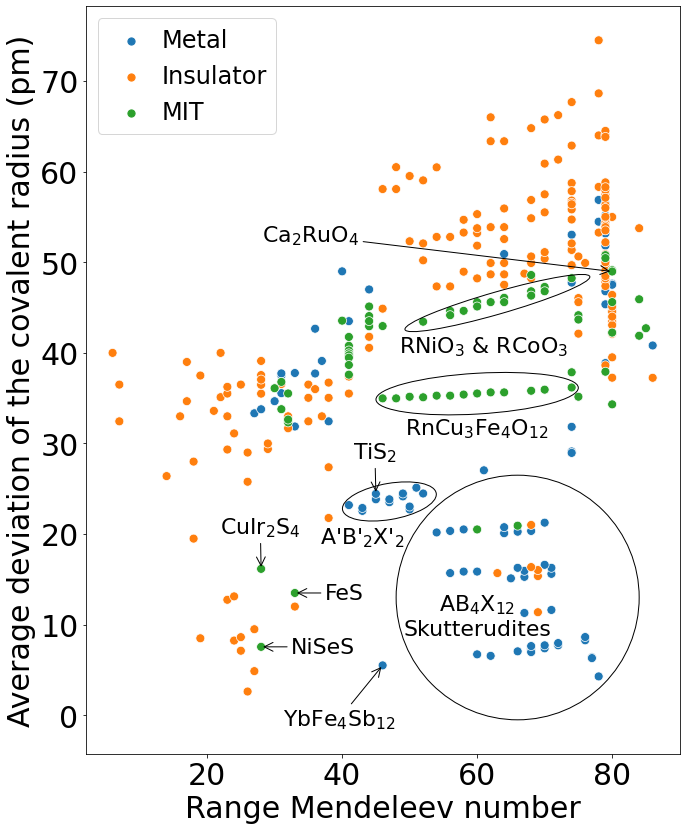

In [38]:
plt.figure(figsize=(10,12))
mendeleev_cov_radius = sns.scatterplot(data=df_mendeleev_cov_radius_plot, x=x_plot, y=y_plot, hue="Label", s=80)
mendeleev_cov_radius.set_xlabel("Range Mendeleev number", fontsize=30)
mendeleev_cov_radius.set_ylabel("Average deviation of the covalent radius (pm)", fontsize=30)
mendeleev_cov_radius.legend(loc='upper left', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
mendeleev_cov_radius.tick_params(labelsize=30)
# define ellipse around Skutterudites
skutterudite_ellip = Ellipse((66, 13), height=15*1.8, width=20*1.8, fill=False, color="black")
mendeleev_cov_radius.add_patch(skutterudite_ellip)
# annotate Skutterudites
mendeleev_cov_radius.text(s="AB$_4$X$_{12}$\nSkutterudites", x=60, y=11, ha="center", va="center")
# define ellipse around RnCu3Fe4O12
RnCu3Fe4O12_ellip = Ellipse((60, 35.5), height=4.5, width=30, fill=False, color="black", angle=2.5)
mendeleev_cov_radius.add_patch(RnCu3Fe4O12_ellip)
# annotate RnCu3Fe4O12
mendeleev_cov_radius.text(s="RnCu$_3$Fe$_4$O$_{12}$", x=60, y=33, ha="center", va="top")
# define ellipse around RNiO3 and RCoO3
RXO3_ellip = Ellipse((63, 45.5), height=2.5, width=28, fill=False, color="black", angle=12)
mendeleev_cov_radius.add_patch(RXO3_ellip)
# annotate RNiO3 and RCoO3
mendeleev_cov_radius.text(s="RNiO$_3$ & RCoO$_3$", x=61, y=42, ha="center", va="top")
# define ellipse around A'B'2X'2
AB2X2_ellip = Ellipse((47, 23.6), height=4, width=14, fill=False, color="black", angle=7)
mendeleev_cov_radius.add_patch(AB2X2_ellip)
# annotate A'B'2X'2
mendeleev_cov_radius.text(s="A'B'$_2$X'$_2$", x=43, y=21, ha="center", va="top")
# annotate TiS2
mendeleev_cov_radius.annotate(r"TiS$_2$", (df_mendeleev_cov_radius_plot[x_plot][89], df_mendeleev_cov_radius_plot[y_plot][89]), 
                              textcoords = "offset points", xytext = (-23, 35), arrowprops=dict(arrowstyle = "->"))
# annotate FeS
mendeleev_cov_radius.annotate(r"FeS", (df_mendeleev_cov_radius_plot[x_plot][293], df_mendeleev_cov_radius_plot[y_plot][293]), 
                              textcoords = "offset points", xytext = (30, -6), arrowprops=dict(arrowstyle = "->"))
# annotate NiSeS
mendeleev_cov_radius.annotate(r"NiSeS", (df_mendeleev_cov_radius_plot[x_plot][313], df_mendeleev_cov_radius_plot[y_plot][313]), 
                              textcoords = "offset points", xytext = (30, -6), arrowprops=dict(arrowstyle = "->"))
# annotate CuIr2S4
mendeleev_cov_radius.annotate(r"CuIr$_2$S$_4$", (df_mendeleev_cov_radius_plot[x_plot][282], df_mendeleev_cov_radius_plot[y_plot][282]), 
                              textcoords = "offset points", xytext = (-41, 35), arrowprops=dict(arrowstyle = "->"))
# annotate YbFe4Sb12
mendeleev_cov_radius.annotate(r"YbFe$_4$Sb$_{12}$", (df_mendeleev_cov_radius_plot[x_plot][95], df_mendeleev_cov_radius_plot[y_plot][95]), 
                              textcoords = "offset points", xytext = (-100, -60), arrowprops=dict(arrowstyle = "->"))
# annotate Ca2RuO4
mendeleev_cov_radius.annotate(r"Ca$_2$RuO$_4$", (df_mendeleev_cov_radius_plot[x_plot][277], df_mendeleev_cov_radius_plot[y_plot][277]), 
                              textcoords = "offset points", xytext = (-350, 30), arrowprops=dict(arrowstyle = "->"))
plt.tight_layout()

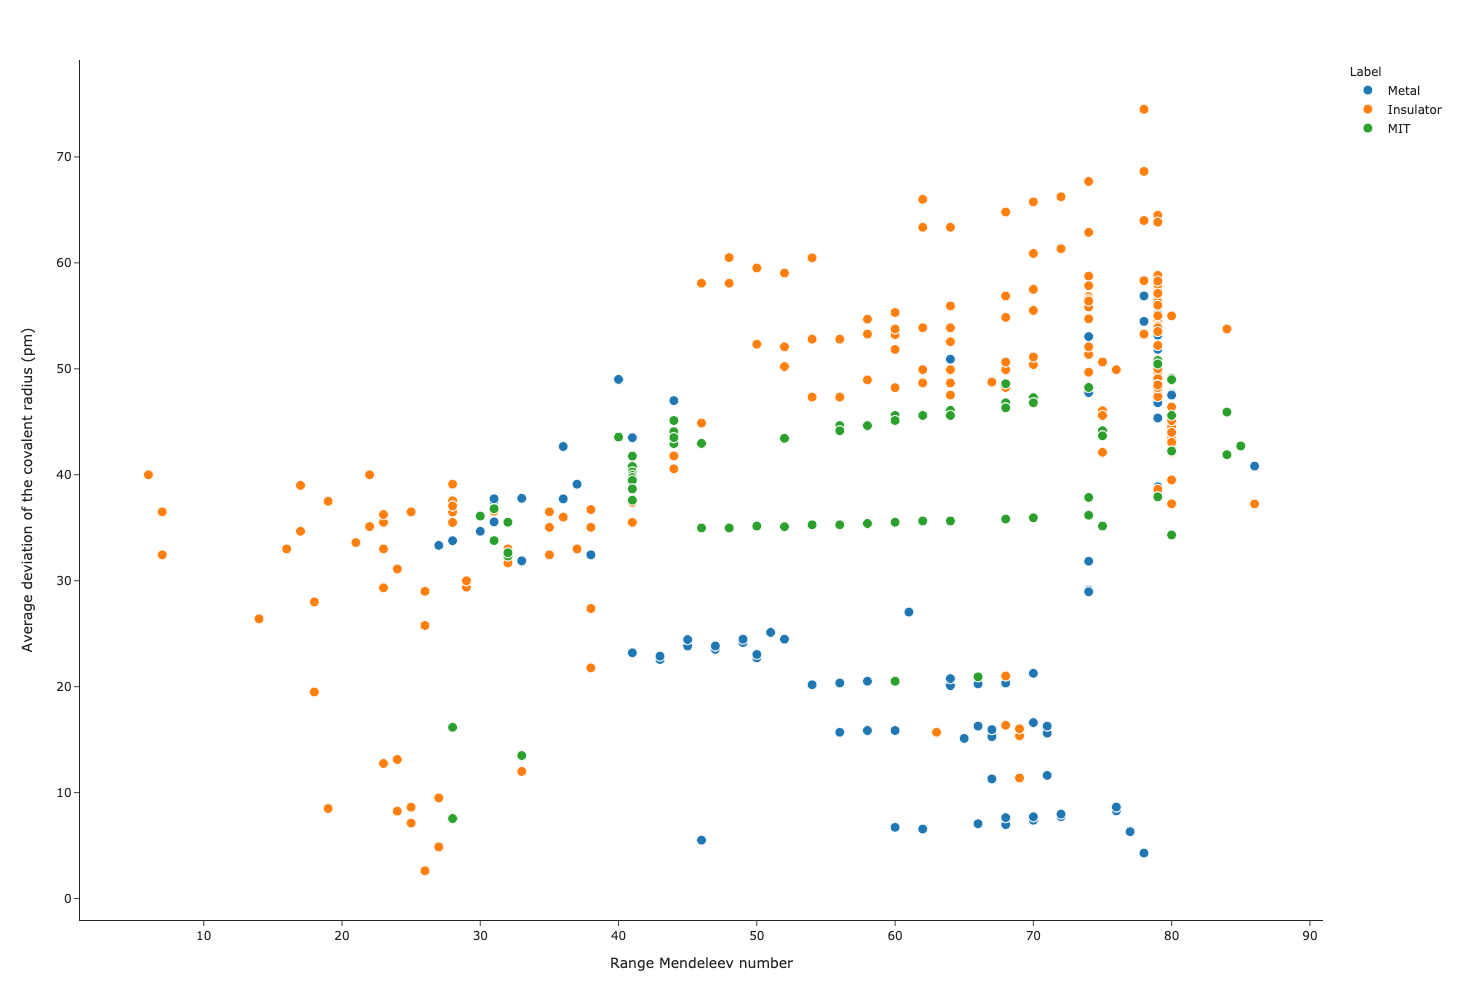

In [39]:
mendeleev_cov_radius_fig = px.scatter(df_plot, x=x_plot, y=y_plot, hover_name="Compound", 
                                      height=1000, width=1000, color="Label", template="simple_white",
                                      labels={
                                          x_plot: "Range Mendeleev number",
                                          y_plot: "Average deviation of the covalent radius (pm)"
                                      }, hover_data=[df_plot.index])
mendeleev_cov_radius_fig.update_traces(mode='markers', marker_line_width=1, marker_size=10, marker_line_color="white")
mendeleev_cov_radius_fig.show()
mendeleev_cov_radius_fig.write_html(SAVE_PATH + "class_separation_interactive.html")

In [40]:
if SAVE_PLOT: mendeleev_cov_radius.figure.savefig(SAVE_PATH + "class_separation_new.pdf", dpi=300, bbox_inches="tight")

# Plot the average metal-metal distance vs. the range of Mendeleev number

In [41]:
x_plot = "range_MendeleevNumber"
y_plot = "avg_mm_dists"
# get the relevant columns from the training set
df_mendeleev_mm_dists_plot = df_plot[["Compound", "Label", x_plot, y_plot]]
df_mendeleev_mm_dists_plot

Compound  Label  range_MendeleevNumber  avg_mm_dists
0      Ba(FeSb3)4  Metal                     76      4.601000
1        Ba(NiP)2  Metal                     74      2.790950
2        Ba(PIr)2  Metal                     74      2.790243
3        Ba(PRh)2  Metal                     74      2.785294
4      Ba(Sb3Os)4  Metal                     76      4.670000
..            ...    ...                    ...           ...
338           VO2    MIT                     41      3.522330
339         YCoO3    MIT                     75      3.716576
340   YFe4(CuO4)3    MIT                     75      3.653850
341         YNiO3    MIT                     75      3.755161
342  YbFe4(CuO4)3    MIT                     48      3.653190

[343 rows x 4 columns]

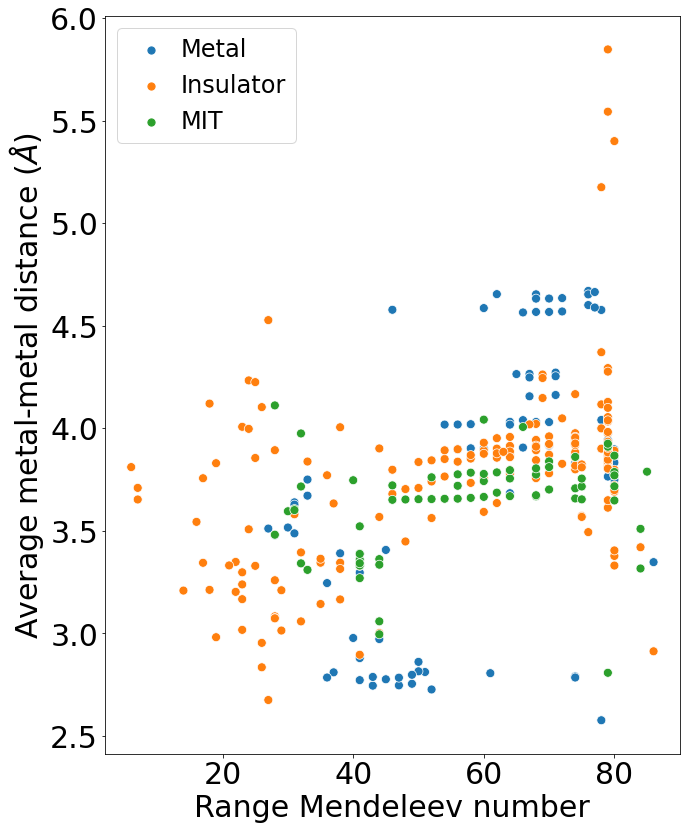

In [42]:
plt.figure(figsize=(10,12))
mendeleev_mm_dists = sns.scatterplot(data=df_mendeleev_mm_dists_plot, x=x_plot, y=y_plot, hue="Label", s=80)
mendeleev_mm_dists.set_xlabel("Range Mendeleev number", fontsize=30)
mendeleev_mm_dists.set_ylabel("Average metal-metal distance ($\AA$)", fontsize=30)
mendeleev_mm_dists.legend(loc='upper left', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
mendeleev_mm_dists.tick_params(labelsize=30)
plt.tight_layout()

In [43]:
if SAVE_PLOT: mendeleev_mm_dists.figure.savefig(SAVE_PATH + "mendeleev_vs_avg_mm_dists.pdf", dpi=300, bbox_inches="tight")

# Plot the Average Deviation of the Covalent Radius vs. the Average Deviation of the Electronegativity

In [44]:
x_plot = "avg_dev_Electronegativity"
y_plot = "avg_dev_CovalentRadius"
# get the relevant columns from the training set
df_adcr_electronegativity_plot = df_plot[["Compound", "Label", x_plot, y_plot]]
df_adcr_electronegativity_plot

Compound  Label  avg_dev_Electronegativity  avg_dev_CovalentRadius
0      Ba(FeSb3)4  Metal                   0.169412                8.608997
1        Ba(NiP)2  Metal                   0.371200               31.840000
2        Ba(PIr)2  Metal                   0.417600               29.120000
3        Ba(PRh)2  Metal                   0.430400               28.960000
4      Ba(Sb3Os)4  Metal                   0.132595                8.276817
..            ...    ...                        ...                     ...
338           VO2    MIT                   0.804444               38.666667
339         YCoO3    MIT                   0.907200               44.160000
340   YFe4(CuO4)3    MIT                   0.796800               35.160000
341         YNiO3    MIT                   0.900000               43.680000
342  YbFe4(CuO4)3    MIT                   0.794400               34.980000

[343 rows x 4 columns]

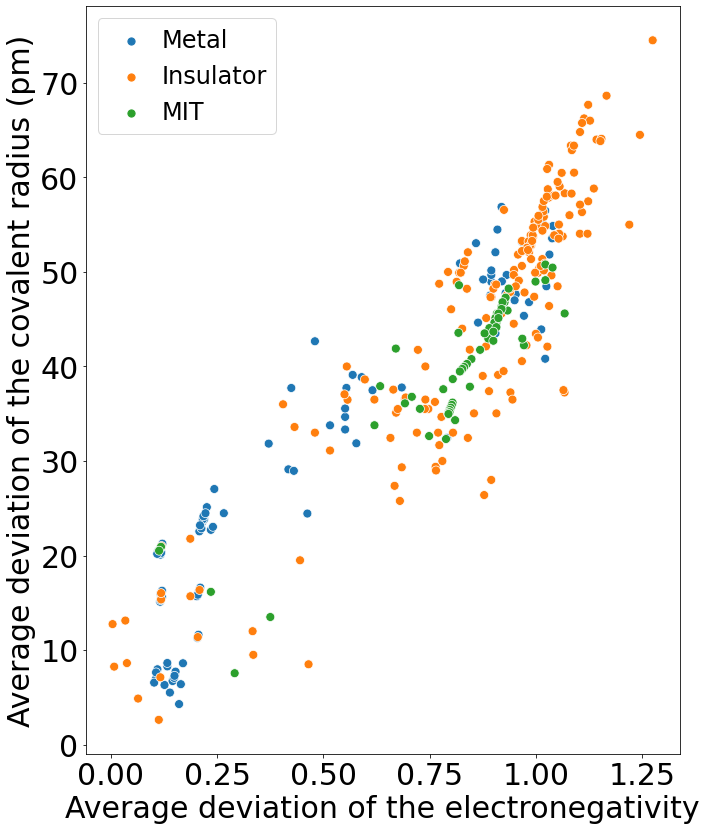

In [45]:
plt.figure(figsize=(10,12))
adcr_electronegativity = sns.scatterplot(data=df_adcr_electronegativity_plot, x=x_plot, y=y_plot, hue="Label", s=80)
adcr_electronegativity.set_xlabel("Average deviation of the electronegativity", fontsize=30)
adcr_electronegativity.set_ylabel("Average deviation of the covalent radius (pm)", fontsize=30)
adcr_electronegativity.legend(loc='upper left', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
adcr_electronegativity.tick_params(labelsize=30)
plt.tight_layout()

In [46]:
if SAVE_PLOT: adcr_electronegativity.figure.savefig(SAVE_PATH + "adcr_vs_avg_dev_electronegativity.pdf", dpi=300, bbox_inches="tight")

# Plot the Ewald Energy per Atom vs. the Average Deviation of the Covalent Radius

In [47]:
x_plot = "avg_dev_CovalentRadius"
y_plot = "ewald_energy_per_atom"
# get the relevant columns from the training set
df_adcr_ewald_plot = df_plot[["Compound", "Label", x_plot, y_plot]]
df_adcr_ewald_plot

Compound  Label  avg_dev_CovalentRadius  ewald_energy_per_atom
0      Ba(FeSb3)4  Metal                8.608997             -12.916613
1        Ba(NiP)2  Metal               31.840000             -29.022094
2        Ba(PIr)2  Metal               29.120000             -27.929343
3        Ba(PRh)2  Metal               28.960000             -28.030653
4      Ba(Sb3Os)4  Metal                8.276817             -12.725768
..            ...    ...                     ...                    ...
338           VO2    MIT               38.666667             -47.781257
339         YCoO3    MIT               44.160000             -34.679490
340   YFe4(CuO4)3    MIT               35.160000             -37.225832
341         YNiO3    MIT               43.680000             -34.202393
342  YbFe4(CuO4)3    MIT               34.980000             -35.600500

[343 rows x 4 columns]

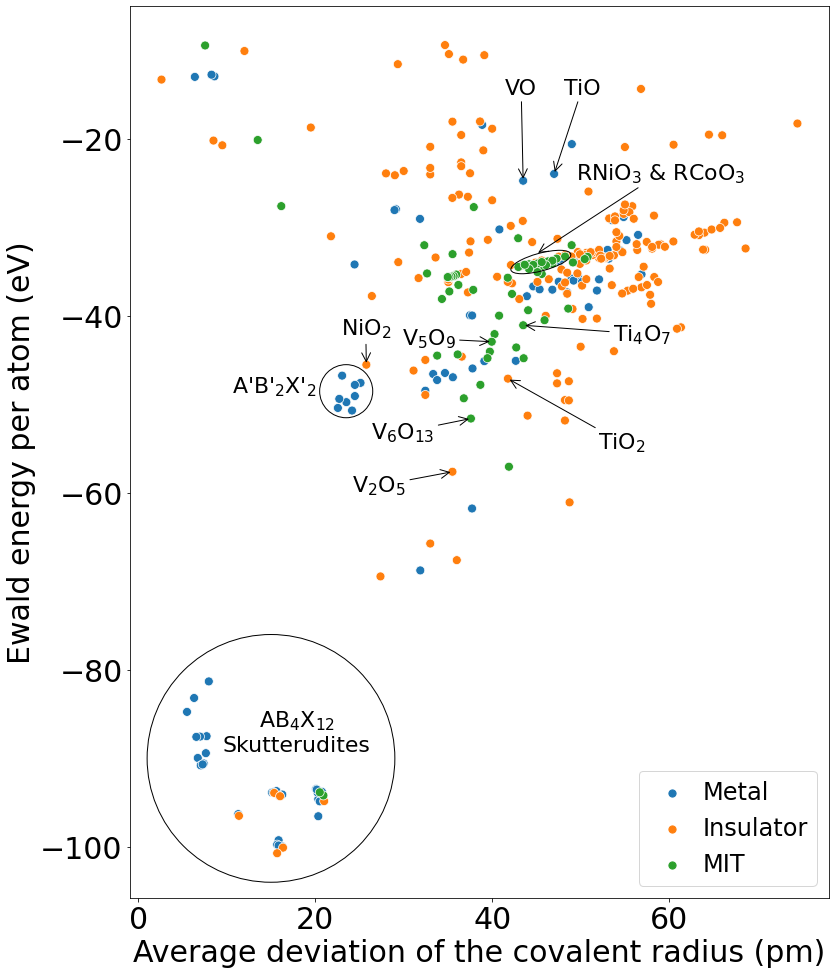

In [48]:
plt.figure(figsize=(14,14))
adcr_ewald = sns.scatterplot(data=df_adcr_ewald_plot, x=x_plot, y=y_plot, hue="Label", s=80)
adcr_ewald.set_xlabel("Average deviation of the covalent radius (pm)", fontsize=30)
adcr_ewald.set_ylabel("Ewald energy per atom (eV)", fontsize=30)
adcr_ewald.set_ylim(top=-5)
adcr_ewald.set_aspect("equal")
adcr_ewald.legend(loc='lower right', fontsize=24, markerscale=1.2, frameon=True, handletextpad=0.25)
adcr_ewald.tick_params(labelsize=30)
# create the circle around Skutterudites
skutterudite_circ = Circle((15, -90), radius=14, fill=False)
adcr_ewald.add_patch(skutterudite_circ)
# annotate the Skutterudites
adcr_ewald.annotate("AB$_4$X$_{12}$\nSkutterudites", (df_adcr_ewald_plot[x_plot][17], df_adcr_ewald_plot[y_plot][17]), 
                     textcoords = "offset points", xytext = (90, -15), ha="center")
# create the circle around A'B'2X'2
AB2X2_circ = Circle((23.5, -48.5), radius=3, fill=False)
adcr_ewald.add_patch(AB2X2_circ)
# annotate A'B'2X'2
adcr_ewald.annotate("A'B'$_2$X'$_2$", (df_adcr_ewald_plot[x_plot][85], df_adcr_ewald_plot[y_plot][85]), 
                    textcoords = "offset points", xytext = (-110, -17))
# define ellipse around RNiO3 and RCoO3
RXO3_ellip = Ellipse((45.5, -33.9), height=2, width=7, fill=False, color="black", angle=15)
adcr_ewald.add_patch(RXO3_ellip)
# annotate RNiO3 and RCoO3
adcr_ewald.annotate("RNiO$_3$ & RCoO$_3$", (45, -33), 
                    textcoords = "offset points", xytext = (40, 75), arrowprops=dict(arrowstyle = "->"))
# annotate NiO2
adcr_ewald.annotate(r"NiO$_2$", (df_adcr_ewald_plot[x_plot][199], df_adcr_ewald_plot[y_plot][199]), 
                    textcoords = "offset points", xytext = (-25.8, 30), arrowprops=dict(arrowstyle = "->"))
# annotate TiO
adcr_ewald.annotate(r"TiO", (df_adcr_ewald_plot[x_plot][88], df_adcr_ewald_plot[y_plot][88]), 
                    textcoords = "offset points", xytext = (10, 80), arrowprops=dict(arrowstyle = "->"))
# annotate VO
adcr_ewald.annotate(r"VO", (df_adcr_ewald_plot[x_plot][92], df_adcr_ewald_plot[y_plot][92]), 
                    textcoords = "offset points", xytext = (-18, 87), arrowprops=dict(arrowstyle = "->"))
# annotate V5O9
adcr_ewald.annotate(r"V$_5$O$_9$", (df_adcr_ewald_plot[x_plot][334], df_adcr_ewald_plot[y_plot][334]), 
                    textcoords = "offset points", xytext = (-90, -3), arrowprops=dict(arrowstyle = "->"))
# annotate V6O13
adcr_ewald.annotate(r"V$_6$O$_{13}$", (df_adcr_ewald_plot[x_plot][336], df_adcr_ewald_plot[y_plot][336]), 
                    textcoords = "offset points", xytext = (-100, -20), arrowprops=dict(arrowstyle = "->"))
# annotate V2O5
adcr_ewald.annotate(r"V$_2$O$_5$", (df_adcr_ewald_plot[x_plot][265], df_adcr_ewald_plot[y_plot][265]), 
                    textcoords = "offset points", xytext = (-100, -20), arrowprops=dict(arrowstyle = "->"))
# annotate Ti4O7
adcr_ewald.annotate(r"Ti$_4$O$_7$", (df_adcr_ewald_plot[x_plot][328], df_adcr_ewald_plot[y_plot][328]), 
                    textcoords = "offset points", xytext = (90, -15), arrowprops=dict(arrowstyle = "->"))
# annotate TiO2
adcr_ewald.annotate(r"TiO$_2$", (df_adcr_ewald_plot[x_plot][260], df_adcr_ewald_plot[y_plot][260]), 
                    textcoords = "offset points", xytext = (90, -70), arrowprops=dict(arrowstyle = "->"))
plt.tight_layout()

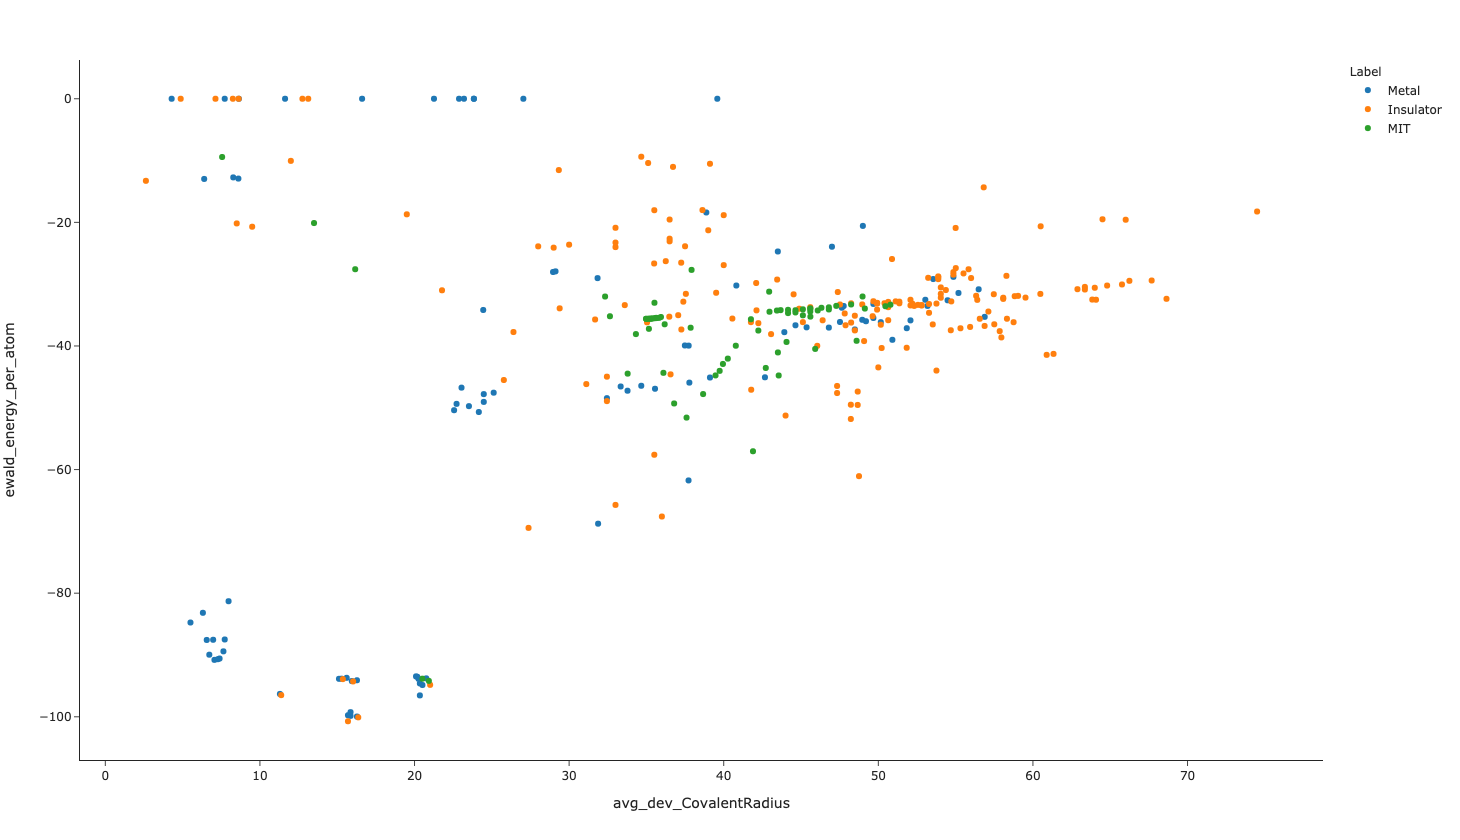

In [49]:
adcr_ewald_fig = px.scatter(df_adcr_ewald_plot, x=x_plot, y=y_plot, hover_name="Compound", 
                            hover_data=[df_adcr_ewald_plot.index], color="Label", template="simple_white", 
                            width=500*1.4, height=600*1.4)
adcr_ewald_fig.show()

In [50]:
if SAVE_PLOT: adcr_ewald.figure.savefig(SAVE_PATH + "adcr_ewald.pdf", dpi=300, bbox_inches="tight")

# Dataset summary plot

First define the subplot dataset and variables

In [51]:
df_metal = pd.read_excel(METAL_SUMMARY_PATH)
df_insulator = pd.read_excel(INSULATOR_SUMMARY_PATH)
df_mit = pd.read_excel(MIT_SUMMARY_PATH)

x_metal, y_metal = "volume_per_site", "rho_300K(Ohm_cm)"
x_insulator, y_insulator = "band_gap", "ref_index"
x_mit, y_mit = "d_valence", "Tmit"

## Plotly figure for annotation

The interactive plots may not show up correctly without the plotly extension in JupyterLab.

### Metals

# of metals plotted: 46


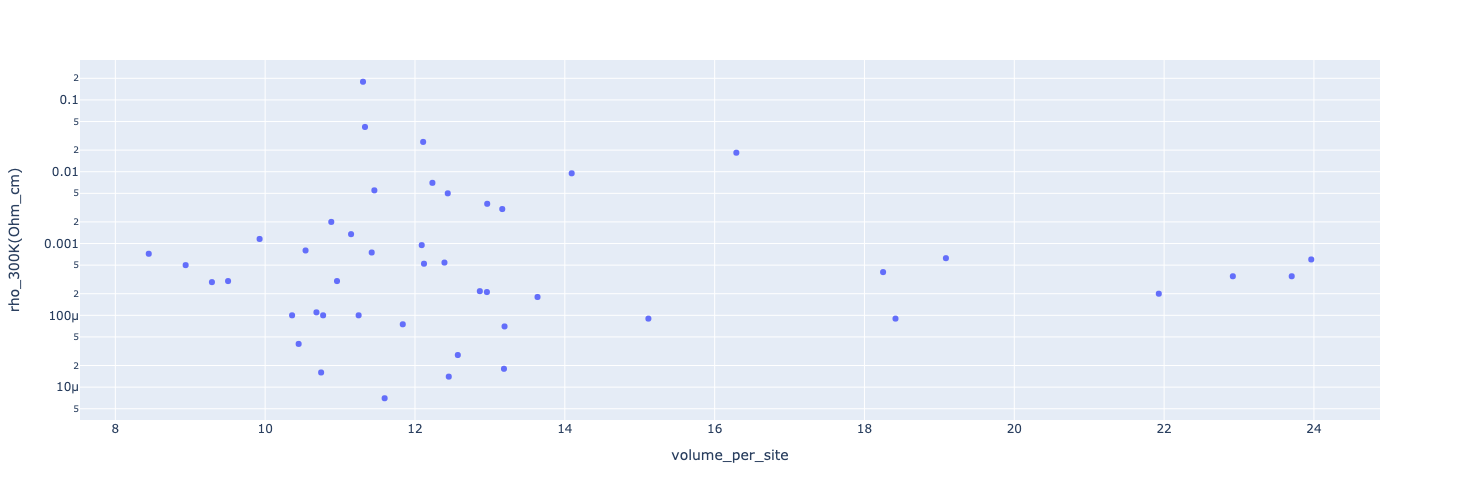

In [52]:
print("# of metals plotted: {}".format(df_metal.dropna().shape[0]))
metal_fig = px.scatter(df_metal, x=x_metal, y=y_metal, hover_name="Compound", 
                       height=500, width=1000, hover_data=[df_metal.index], log_y=True)
metal_fig.show()

### Insulators

# of insulators plotted: 100


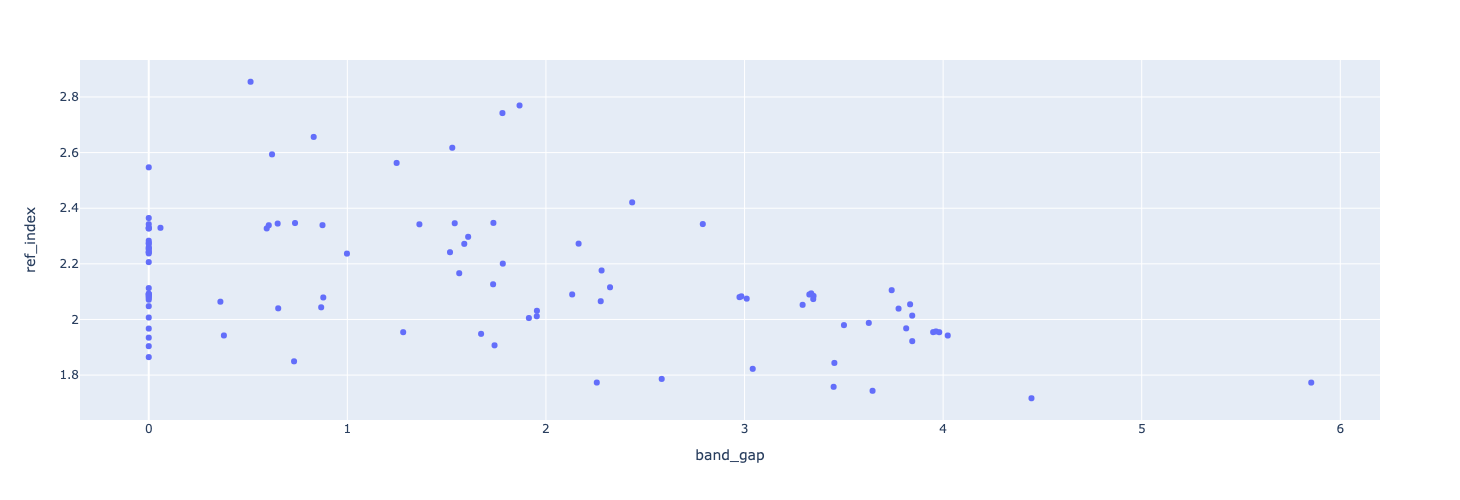

In [53]:
print("# of insulators plotted: {}".format(df_insulator.dropna().shape[0]))
insulator_fig = px.scatter(df_insulator, x=x_insulator, y=y_insulator, hover_name="Compound", 
                           height=500, width=1000, hover_data=[df_insulator.index])
insulator_fig.show()

### MITs

# of MITs plotted: 67


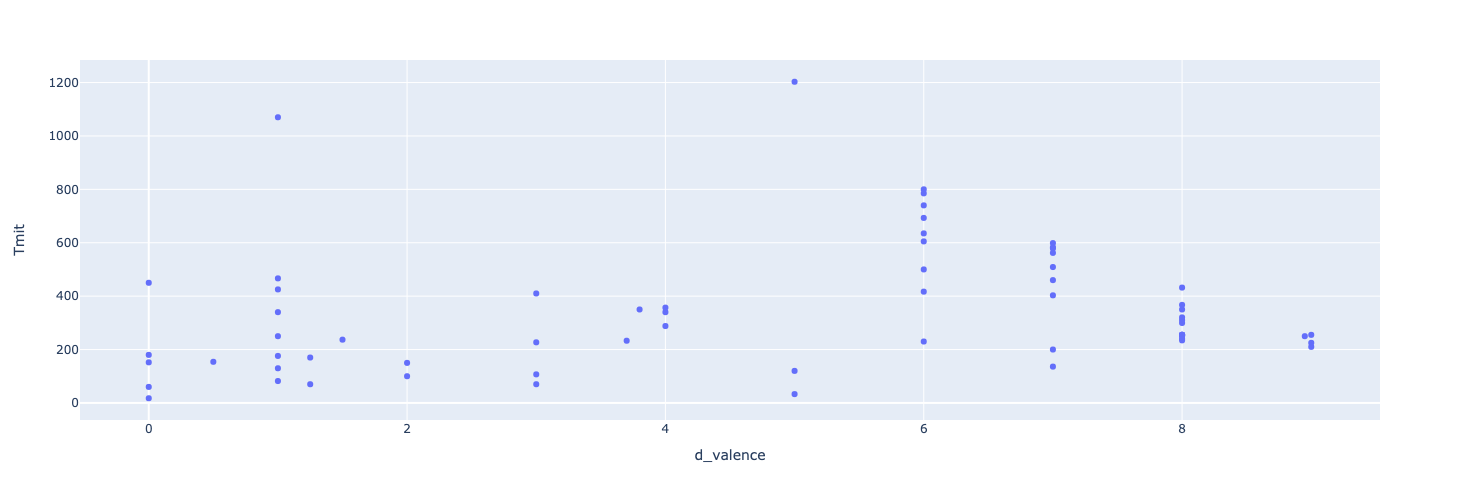

In [54]:
print("# of MITs plotted: {}".format(df_mit.dropna().shape[0]))
mit_fig = px.scatter(df_mit, x=x_mit, y=y_mit, hover_name="Compound", 
                     height=500, width=1000, hover_data=[df_mit.index])
mit_fig.show()

### Static image

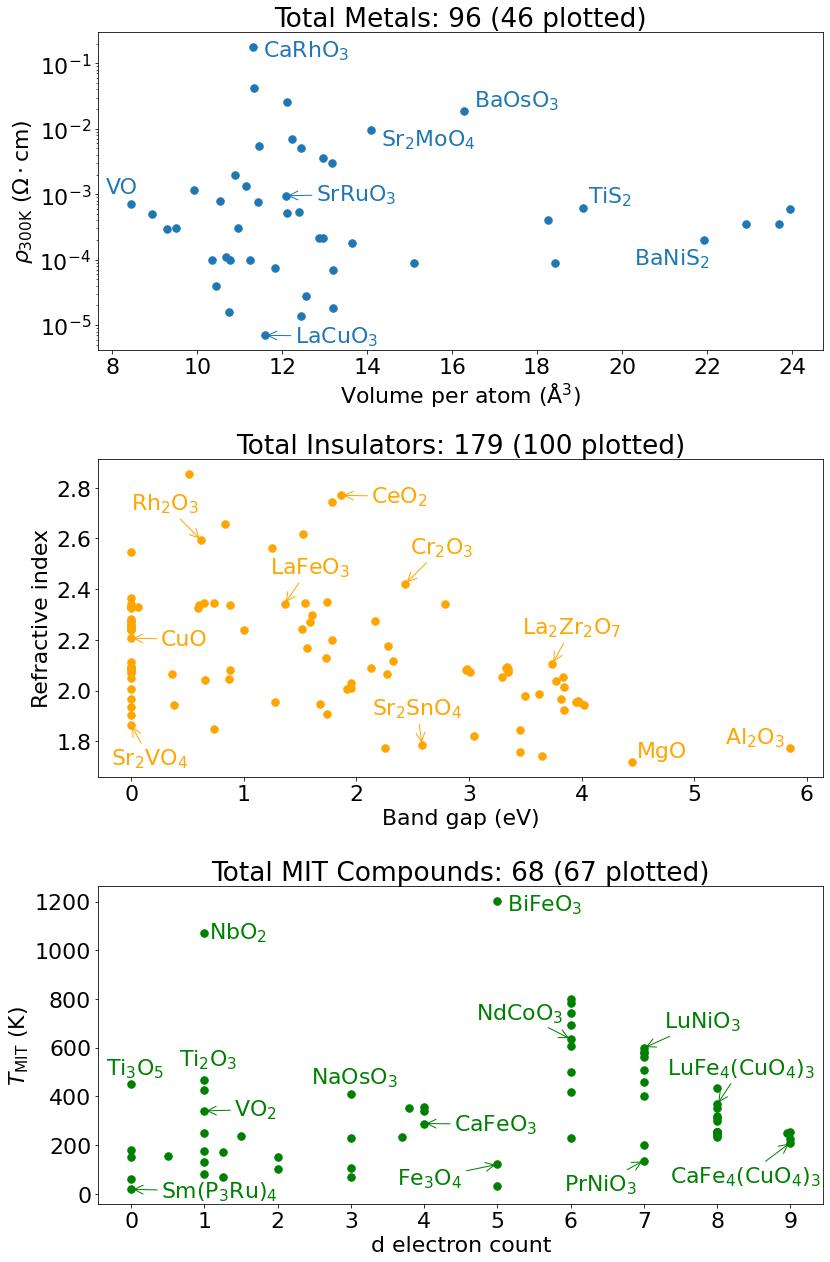

In [55]:
MARKERSIZE = 15

summary_plot, ax = plt.subplots(3,1, figsize = (12, 18))

# metal subplot
ax[0].plot(df_metal[x_metal], df_metal[y_metal], ".", markersize = MARKERSIZE)
ax[0].set_yscale("log")
ax[0].set_xlabel(r"Volume per atom ($\mathrm{\AA}^3$)")
ax[0].set_ylabel(r"$\rho_{300 \mathrm{K}}$ ($\Omega\cdot$cm)")
ax[0].set_title("Total Metals: {} ({} plotted)".format(df_metal.shape[0], df_metal.dropna().shape[0]))
# annotate CaRhO3
ax[0].annotate(r"CaRhO$_3$", (df_metal[x_metal][7], df_metal[y_metal][7]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (10, -10))
# annotate VO
ax[0].annotate(r"VO", (df_metal[x_metal][38], df_metal[y_metal][38]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (-25, 10))
# annotate Sr2MoO4
ax[0].annotate(r"Sr$_2$MoO$_4$", (df_metal[x_metal][22], df_metal[y_metal][22]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (10, -15))
# annotate BaOsO3
ax[0].annotate(r"BaOsO$_3$", (df_metal[x_metal][2], df_metal[y_metal][2]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (10, 5))
# annotate TiS2
ax[0].annotate(r"TiS$_2$", (df_metal[x_metal][36], df_metal[y_metal][36]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (5, 5))
# annotate BaNiS2
ax[0].annotate(r"BaNiS$_2$", (df_metal[x_metal][1], df_metal[y_metal][1]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (-70, -25))
# annotate SrRuO3
ax[0].annotate(r"SrRuO$_3$", (df_metal[x_metal][33], df_metal[y_metal][33]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (30, -5),
               arrowprops=dict(color="#1f77b4", arrowstyle = "->"))
# annotate LaCuO3
ax[0].annotate(r"LaCuO$_3$", (df_metal[x_metal][10], df_metal[y_metal][10]), 
               color = "#1f77b4", textcoords = "offset points", xytext = (30, -7),
               arrowprops=dict(color="#1f77b4", arrowstyle = "->"))


# insulator subplot
ax[1].plot(df_insulator[x_insulator], df_insulator[y_insulator], ".", color="orange", markersize = MARKERSIZE)
ax[1].set_xlabel("Band gap (eV)") 
ax[1].set_ylabel("Refractive index")
ax[1].set_title("Total Insulators: {} ({} plotted)".format(df_insulator.shape[0], df_insulator.dropna().shape[0]))
# annotate CuO
ax[1].annotate(r"CuO", (df_insulator[x_insulator][34], df_insulator[y_insulator][34]), 
               color = "orange", textcoords = "offset points", xytext = (30, -7),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate Sr2VO4
ax[1].annotate(r"Sr$_2$VO$_4$", (df_insulator[x_insulator][101], df_insulator[y_insulator][101]), 
               color = "orange", textcoords = "offset points", xytext = (-20, -40),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate Rh2O3
ax[1].annotate(r"Rh$_2$O$_3$", (df_insulator[x_insulator][82], df_insulator[y_insulator][82]), 
               color = "orange", textcoords = "offset points", xytext = (-70, 30),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate CeO2
ax[1].annotate(r"CeO$_2$", (df_insulator[x_insulator][23], df_insulator[y_insulator][23]), 
               color = "orange", textcoords = "offset points", xytext = (30, -7),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate Cr2O3
ax[1].annotate(r"Cr$_2$O$_3$", (df_insulator[x_insulator][29], df_insulator[y_insulator][29]), 
               color = "orange", textcoords = "offset points", xytext = (5, 30),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate La2Zr2O7
ax[1].annotate(r"La$_2$Zr$_2$O$_7$", (df_insulator[x_insulator][51], df_insulator[y_insulator][51]), 
               color = "orange", textcoords = "offset points", xytext = (-30, 30),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate Sr2SnO4
ax[1].annotate(r"Sr$_2$SnO$_4$", (df_insulator[x_insulator][99], df_insulator[y_insulator][99]), 
               color = "orange", textcoords = "offset points", xytext = (-50, 30),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate LaFeO3
ax[1].annotate(r"LaFeO$_3$", (df_insulator[x_insulator][53], df_insulator[y_insulator][53]), 
               color = "orange", textcoords = "offset points", xytext = (-15, 30),
               arrowprops=dict(color="orange", arrowstyle = "->"))
# annotate MgO
ax[1].annotate(r"MgO", (df_insulator[x_insulator][61], df_insulator[y_insulator][61]), 
               color = "orange", textcoords = "offset points", xytext = (5, 5))
# annotate Al2O3
ax[1].annotate(r"Al$_2$O$_3$", (df_insulator[x_insulator][1], df_insulator[y_insulator][1]), 
               color = "orange", textcoords = "offset points", xytext = (-65, 5))

# mit subplot
ax[2].plot(df_mit[x_mit], df_mit[y_mit], ".", color="green", markersize = MARKERSIZE)
ax[2].set_xlabel("d electron count")
ax[2].set_ylabel(r"$T_{\mathrm{MIT}}$ (K)")
ax[2].set_xticks(np.linspace(0, 9, 10))
ax[2].set_title("Total MIT Compounds: {} ({} plotted)".format(df_mit.shape[0], df_mit.dropna().shape[0]))
# annotate NbO2
ax[2].annotate(r"NbO$_2$", (df_mit[x_mit][30], df_mit[y_mit][30]), 
               color = "green", textcoords = "offset points", xytext = (5, -5))
# annotate BiFeO3
ax[2].annotate(r"BiFeO$_3$", (df_mit[x_mit][15], df_mit[y_mit][15]), 
               color = "green", textcoords = "offset points", xytext = (10, -10))
# annotate Ti3O5
ax[2].annotate(r"Ti$_3$O$_5$", (df_mit[x_mit][48], df_mit[y_mit][48]), 
               color = "green", textcoords = "offset points", xytext = (-25, 10))
# annotate Sm(P3Ru)4
ax[2].annotate(r"Sm(P$_3$Ru)$_4$", (df_mit[x_mit][40], df_mit[y_mit][40]), 
               color = "green", textcoords = "offset points", xytext = (30, -8),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate Ti2O3
ax[2].annotate(r"Ti$_2$O$_3$", (df_mit[x_mit][47], df_mit[y_mit][47]), 
               color = "green", textcoords = "offset points", xytext = (-25, 15))
# annotate VO2
ax[2].annotate(r"VO$_2$", (df_mit[x_mit][59], df_mit[y_mit][59]), 
               color = "green", textcoords = "offset points", xytext = (30, -5),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate NaOsO3
ax[2].annotate(r"NaOsO$_3$", (df_mit[x_mit][29], df_mit[y_mit][29]), 
               color = "green", textcoords = "offset points", xytext = (-40, 10))
# annotate CaFeO3
ax[2].annotate(r"CaFeO$_3$", (df_mit[x_mit][5], df_mit[y_mit][5]), 
               color = "green", textcoords = "offset points", xytext = (30, -7),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate Fe3O4
ax[2].annotate(r"Fe$_3$O$_4$", (df_mit[x_mit][14], df_mit[y_mit][14]), 
               color = "green", textcoords = "offset points", xytext = (-100, -20),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate NdCoO3
ax[2].annotate(r"NdCoO$_3$", (df_mit[x_mit][32], df_mit[y_mit][32]), 
               color = "green", textcoords = "offset points", xytext = (-95, 20),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate LuNiO3
ax[2].annotate(r"LuNiO$_3$", (df_mit[x_mit][27], df_mit[y_mit][27]), 
               color = "green", textcoords = "offset points", xytext = (20, 20),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate PrNiO3
ax[2].annotate(r"PrNiO$_3$", (df_mit[x_mit][39], df_mit[y_mit][39]), 
               color = "green", textcoords = "offset points", xytext = (-80, -30),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate LuFe4(CuO4)3
ax[2].annotate(r"LuFe$_4$(CuO$_4$)$_3$", (df_mit[x_mit][26], df_mit[y_mit][26]), 
               color = "green", textcoords = "offset points", xytext = (-50, 30),
               arrowprops=dict(color="green", arrowstyle = "->"))
# annotate CaFe4(CuO4)3
ax[2].annotate(r"CaFe$_4$(CuO$_4$)$_3$", (df_mit[x_mit][4], df_mit[y_mit][4]), 
               color = "green", textcoords = "offset points", xytext = (-120, -40),
               arrowprops=dict(color="green", arrowstyle = "->"))

summary_plot.tight_layout()

In [56]:
if SAVE_PLOT: summary_plot.savefig(SAVE_PATH + "data_summary.pdf", dpi=300, bbox_inches="tight")

# Human vs. ML

## Read in ML metric data

In [57]:
df_ml_metrics = pd.read_excel(ML_METRICS_PATH)
df_ml_metrics = df_ml_metrics.loc[(df_ml_metrics.model_type == "XGBClassifier") & 
                                  (df_ml_metrics.metric_name != "roc_auc") & 
                                  (df_ml_metrics.positive_class != "Multiclass")]
df_ml_metrics["raw_metric"] = pd.eval(df_ml_metrics["raw_metric"])
df_ml_metrics = df_ml_metrics.drop(columns=["metric_value", "metric_dispersion"]).explode(column="raw_metric", ignore_index=True)
df_ml_metrics

model_type positive_class         metric_name raw_metric
0   XGBClassifier          Metal  precision_weighted   0.858841
1   XGBClassifier          Metal  precision_weighted   0.869297
2   XGBClassifier          Metal  precision_weighted   0.855072
3   XGBClassifier          Metal  precision_weighted   0.850993
4   XGBClassifier          Metal  precision_weighted    0.87535
..            ...            ...                 ...        ...
85  XGBClassifier            MIT         f1_weighted   0.903435
86  XGBClassifier            MIT         f1_weighted     0.8648
87  XGBClassifier            MIT         f1_weighted   0.873722
88  XGBClassifier            MIT         f1_weighted   0.919316
89  XGBClassifier            MIT         f1_weighted   0.900811

[90 rows x 4 columns]

In [58]:
df_human_metrics = pd.read_csv(HUMAN_METRICS_PATH)
df_human_metrics

model_type positive_class         metric_name  raw_metric
0        Human          Metal  precision_weighted    0.511905
1        Human          Metal  precision_weighted    0.555556
2        Human          Metal  precision_weighted    0.375000
3        Human          Metal  precision_weighted    0.555556
4        Human          Metal  precision_weighted    0.625000
..         ...            ...                 ...         ...
472      Human            MIT         f1_weighted    0.677066
473      Human            MIT         f1_weighted    0.630621
474      Human            MIT         f1_weighted    0.679167
475      Human            MIT         f1_weighted    0.945859
476      Human            MIT         f1_weighted    0.473304

[477 rows x 4 columns]

In [59]:
df_combined_metrics = pd.concat([df_ml_metrics, df_human_metrics], ignore_index=True)
df_combined_metrics

model_type positive_class         metric_name raw_metric
0    XGBClassifier          Metal  precision_weighted   0.858841
1    XGBClassifier          Metal  precision_weighted   0.869297
2    XGBClassifier          Metal  precision_weighted   0.855072
3    XGBClassifier          Metal  precision_weighted   0.850993
4    XGBClassifier          Metal  precision_weighted    0.87535
..             ...            ...                 ...        ...
562          Human            MIT         f1_weighted   0.677066
563          Human            MIT         f1_weighted   0.630621
564          Human            MIT         f1_weighted   0.679167
565          Human            MIT         f1_weighted   0.945859
566          Human            MIT         f1_weighted   0.473304

[567 rows x 4 columns]

## Define a helper function to select relevant metrics

In [60]:
def get_metric(pos_class, df_input):
    """A helper function to select the raw metric value the given positive class"""
    df_selected = df_input.loc[df_input.positive_class == pos_class]
    return df_selected

## Define plot constants

In [61]:
MIT_TITLE = "T"
METAL_TITLE = "M"
INSULATOR_TITLE = "I"
TITLES = [METAL_TITLE, INSULATOR_TITLE, MIT_TITLE]

TICK_SIZE = 19
BARWIDTH = 0.2
CAPSIZE = 5

## Compare performance

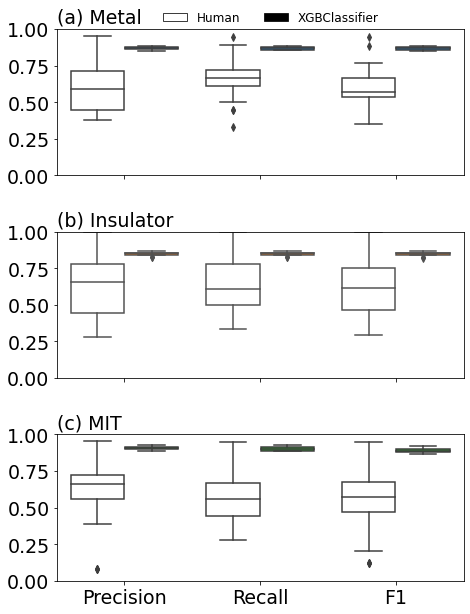

In [62]:
f, axarr = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(7, 9))

pos_classes = ["Metal", "Insulator", "MIT"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot the three subplots in the order of "Metal", "Insulator", "MIT"
for i, (pos_class, color) in enumerate(zip(pos_classes, colors)):
    tit = ['(a) Metal', '(b) Insulator', '(c) MIT'][i]
    ax = sns.boxplot(data=get_metric(pos_class, df_combined_metrics), x="metric_name", y="raw_metric", hue="model_type", hue_order=["Human", "XGBClassifier"], 
                     palette=sns.color_palette(("w", color)), saturation=1, ax=axarr[i])
    axarr[i] = ax
    if i == 0:
        axarr[i].legend(frameon=False, loc=(0.25, 1),
                        ncol=2, fontsize=12)
        leg = axarr[i].get_legend()
        leg.legendHandles[0].set_color("white")
        leg.legendHandles[0].set_edgecolor("black")
        leg.legendHandles[1].set_color("black")
    else:
        axarr[i].get_legend().remove()
    
    axarr[i].set_xlabel(None)
    axarr[i].set_ylabel(None)
    axarr[i].set_ylim(0, 1.0)
    axarr[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    axarr[i].set_title(tit, loc='left', fontsize=TICK_SIZE)
    axarr[i].tick_params(labelsize=TICK_SIZE)
    
f.subplots_adjust(hspace=0.1)
# Hide x labels and tick labels for all but bottom plot.
plt.xticks((0, 1, 2), ('Precision', 'Recall', 'F1'))
plt.tight_layout()

In [63]:
if SAVE_PLOT: f.savefig(SAVE_PATH + "human_ml_comparison.pdf", dpi=300, bbox_inches="tight")